In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from shapely import Polygon
from shapely import MultiPolygon
import h3.api.numpy_int as h3
from netCDF4 import Dataset
import cartopy.crs as ccrs
import xarray as xr
from itertools import product
import pysal as ps
import libpysal
from sklearn.cluster import AffinityPropagation
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import OPTICS
import scipy.sparse

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/pysal/explore/segregation/network/network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
def aff_prop_labels(idxs,obu,obv):
    # define features for clustering:
    # 1. u-component
    # 2. v-component
    # predictors are stored in a matrix of {n_samples, n_features}
    n_feat = 2
    X = np.nan * np.ones((np.size(idxs),n_feat))
    X[:,0] = obu[idxs]
    X[:,1] = obv[idxs]
    # define settings for affinity propagation and generate clustering
    # see for details:
    # https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html#sklearn.cluster.AffinityPropagation
    dampCoef  = 0.70  # can be increased up to 0.95, if not converging - lower value may or may not produce more indiv. clusters
    iterMax   = 500   # set higher than iterCnv
    iterCnv   = 50   # can be increased if not converging (try increasing dampCoef first, though)
    cop       = True
    pref      = None
    affTyp    = 'euclidean'
    outVerb   = False
    randState = 90210  # sets random number seed, for reproducibility
    clustering = AffinityPropagation(
                                     damping=dampCoef,
                                     max_iter=iterMax,
                                     convergence_iter=iterCnv,
                                     copy=cop,
                                     preference=pref,
                                     affinity=affTyp,
                                     verbose=outVerb,
                                     random_state=randState
                                    ).fit(X)
    return clustering.labels_

def optics_labels(idxs,obu,obv):
    # define features for clustering:
    # 1. u-component
    # 2. v-component
    # predictors are stored in a matrix of {n_samples, n_features}
    n_feat = 2
    X = np.nan * np.ones((np.size(idxs),n_feat))
    X[:,0] = obu[idxs]
    X[:,1] = obv[idxs]
    # define settings for affinity propagation and generate clustering
    # see for details:
    # https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html#sklearn.cluster.AffinityPropagation
    dampCoef  = 0.70  # can be increased up to 0.95, if not converging - lower value may or may not produce more indiv. clusters
    iterMax   = 500   # set higher than iterCnv
    iterCnv   = 50   # can be increased if not converging (try increasing dampCoef first, though)
    cop       = True
    pref      = None
    affTyp    = 'euclidean'
    outVerb   = False
    randState = 90210  # sets random number seed, for reproducibility
    clustering = OPTICS(
                        min_samples=12,          # how many obs necessary to create a cluster
                        max_eps=np.sqrt(2*7.),  # how close in X-space obs need to be to be clustered
                        n_jobs=1
                       ).fit(X)
    return clustering.labels_

In [3]:
data_dir='test-data/ops.v16.3.2023040300'
diag_file=data_dir+'/diag_conv_uv_ges.2023040300.nc4'
diag_hdl=Dataset(diag_file)
ob_use=np.asarray(diag_hdl.variables['Analysis_Use_Flag']).squeeze()
ob_typ=np.asarray(diag_hdl.variables['Observation_Type']).squeeze()
ob_sty=np.asarray(diag_hdl.variables['Observation_Subtype']).squeeze()
ob_pre=np.asarray(diag_hdl.variables['Pressure']).squeeze()
ob_lat=np.asarray(diag_hdl.variables['Latitude']).squeeze()
ob_lon=np.asarray(diag_hdl.variables['Longitude']).squeeze()
ob_tim=np.asarray(diag_hdl.variables['Time']).squeeze()
ob_uwd=np.asarray(diag_hdl.variables['u_Observation']).squeeze()
ob_vwd=np.asarray(diag_hdl.variables['v_Observation']).squeeze()
fix=np.where(ob_lon>180.)
ob_lon[fix]=ob_lon[fix]-360.

In [4]:
# Pre-screening for pressure and time into discrete groups, then use DistanceBand grouping
# and pressure/time NearestNeighbors against all obs to reach out and include obs outside
# of initial screening. Use this expanded group to test for similarity via clustering with
# affinity propagation
#
# Perform similarity-based clustering on DistanceBand connected-groups, which can include
# multiple proximity-based clusters but will contain no observations with proximity-neighbors
# outside of the connected-group.
#
# define index of all qualifiable observations (meeting use and typ requirements)
allidx=np.where((ob_use==1.)&(ob_typ>=240)&(ob_typ<=260))[0]
# define index of all searching observations (meeting pressure and time requirements in subset)
thresPres = 50. # +/- range of pressure bin
thresTime = 1.0  # +/- range of time bin
srcPres = 450.  # center of pressure bin
srcTime = -2.5  # center of time bin
minPres = srcPres - thresPres
maxPres = srcPres + thresPres
minTime = srcTime - thresTime
maxTime = srcTime + thresTime
srcidx=np.intersect1d(allidx,np.where((ob_pre <= maxPres)&(ob_pre >= minPres) &
                                      (ob_tim <= maxTime)&(ob_tim >= minTime))[0])
# define index of all expanding observations (qualifiable and within threshPres and threshTime of pressure/time req.)
minPresExp = minPres - thresPres
maxPresExp = maxPres + thresPres
minTimeExp = minTime - thresTime
maxTimeExp = maxTime + thresTime
expidx=np.intersect1d(allidx,np.where((ob_pre <= maxPresExp)&(ob_pre >= minPresExp) &
                                      (ob_tim <= maxTimeExp)&(ob_tim >= minTimeExp))[0])
print('{:d} observations in total'.format(np.size(allidx)))
print('{:d} observations in search'.format(np.size(srcidx)))
print('{:d} observations in expanded range'.format(np.size(expidx)))

582778 observations in total
20266 observations in search
62364 observations in expanded range


In [5]:
# Construct a geopandas point dataset that contains all relevant ob-info
point_list=[]
nob_list=[]
for i in expidx:
    point_list.append(Point(ob_lon[i],ob_lat[i]))
d = {'geometry': point_list, 
     'lat': list(ob_lat[expidx]),
     'lon': list(ob_lon[expidx]),
     'pre': list(ob_pre[expidx]),
     'tim': list(ob_tim[expidx]),
     'uob': list(ob_uwd[expidx]),
     'vob': list(ob_vwd[expidx]),
     'ob_idx': list(expidx)
    }
gdf = gpd.GeoDataFrame(d, crs="EPSG:4326")
# Transform gdf into cylindrical equidistant projection, where Point() units are in m
gdfE = gdf.to_crs("EPSG:4087")
# Generate neighbors search in pressure and time space with chosen thresholds
neighPres = NearestNeighbors(radius=thresPres)
neighPres.fit(np.reshape(ob_pre[expidx],(-1,1)))
neighTime = NearestNeighbors(radius=thresTime)
neighTime.fit(np.reshape(ob_tim[expidx],(-1,1)))

NearestNeighbors()

In [6]:
# Define weights by a DistanceBand cutoff distance around each ob
distThreshold=1000.*100. # m
w=libpysal.weights.distance.DistanceBand.from_dataframe(gdfE,threshold=distThreshold) # threshold in m

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 3427 disconnected components.
 There are 1726 islands with ids: 24, 25, 28, 39, 40, 45, 294, 1392, 1393, 1394, 1395, 1412, 1437, 1439, 1450, 1459, 1463, 1464, 1473, 1479, 1486, 1487, 1551, 1705, 2832, 3042, 3043, 3045, 3052, 3053, 3054, 3066, 3077, 3086, 3096, 3097, 3119, 3125, 3143, 3144, 3145, 3146, 3147, 3155, 3221, 3229, 3235, 3256, 3258, 3261, 3275, 3289, 3298, 3345, 3346, 3358, 3371, 3434, 4213, 4227, 4273, 4297, 4319, 4333, 4344, 4345, 4355, 4358, 4359, 4360, 4361, 4363, 4364, 4365, 4366, 4368, 4371, 4372, 4380, 4383, 4385, 4387, 4391, 4392, 4393, 4397, 4398, 4402, 4415, 4427, 4438, 4439, 4440, 4443, 4459, 4488, 4490, 4491, 4492, 4493, 4494, 4497, 4502, 4644, 4646, 4648, 4651, 4669, 4694, 5304, 5312, 5337, 5346, 5589, 5599, 5600, 5608, 5634, 5641, 5645, 5651, 5661, 5668, 5676, 5679, 5685, 5694, 5698

In [7]:
# trim islands from gdfE, as these are 1-member clusters by definition, recompute w
gdfE=gdfE.drop(index=w.islands)
gdfE=gdfE.reset_index() # Resets index numbering to start at 0
w = libpysal.weights.distance.DistanceBand.from_dataframe(gdfE,threshold=distThreshold) # threshold in m

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 1701 disconnected components.
  warnings.warn(message)


In [8]:
ws = w.sparse
wt = scipy.sparse.triu(ws)
iprox,jprox=scipy.sparse.find(wt)[0:2]

In [9]:
# attach component-groups to gdfE
gdfE = gdfE.assign(compGroup=w.component_labels)
gdfE

,index,geometry,lat,lon,pre,tim,uob,vob,ob_idx,compGroup
0,0,POINT (111319.491 -9034690.280),-81.160004,1.000000,425.000000,-2.55,-3.314330,13.293052,0,0
1,1,POINT (939536.456 -9013539.305),-80.970001,8.440000,450.000000,-2.55,-13.800393,8.292113,1,1
2,2,POINT (921725.354 -9082556.846),-81.589996,8.280000,437.000000,-2.55,-11.190902,9.062214,2,1
3,3,POINT (551031.458 -9124858.796),-81.970001,4.950000,412.000000,-2.55,-8.955636,14.332013,3,2
4,4,POINT (732482.241 -9122631.931),-81.949997,6.580000,412.000000,-2.55,-10.281547,13.159780,4,1
...,...,...,...,...,...,...,...,...,...,...
60633,62358,POINT (-164529.854 8215490.868),73.801010,-1.477997,500.000000,-1.05,5.332906,9.620817,1850188,1697
60634,62359,POINT (-115960.068 8143677.431),73.155899,-1.041687,512.000000,-1.05,8.776244,8.183980,1850189,1697
60635,62360,POINT (-682287.106 9376833.460),84.233528,-6.129089,419.700012,-0.90,12.279324,-1.725746,1850208,1700
60636,62361,POINT (-646052.557 9362170.290),84.101807,-5.803589,420.200012,-0.90,12.247335,-1.939787,1850210,1700


In [10]:
# extract all component-neighbors from a component of w
ic = 1  # component-label to search on
compIDX = gdfE.loc[gdfE['compGroup']==ic].index
print('{:d} observations in component sub-group'.format(np.size(compIDX)))
# compute pressure and time proximity-neighbor lists among simidx[compIDX]
neighPresList = neighPres.radius_neighbors(np.reshape(ob_pre[expidx[compIDX]],(-1,1)),return_distance=False)
neighTimeList = neighTime.radius_neighbors(np.reshape(ob_tim[expidx[compIDX]],(-1,1)),return_distance=False)
# compute equivalent space proximity-neighbor list
neighSpacList = np.empty((np.shape(neighPresList)),dtype='O')
for i in range(np.size(compIDX)):
    neighSpacList[i] = jprox[np.where(iprox==compIDX[i])]
neighSpacList
gdfEsub = gdfE.loc[gdfE['compGroup']==ic]
#gdfEsub = gdfEsub.reset_index()
gdfEsub

6006 observations in component sub-group


,index,geometry,lat,lon,pre,tim,uob,vob,ob_idx,compGroup
1,1,POINT (939536.456 -9013539.305),-80.970001,8.440000,450.0,-2.55,-13.800393,8.292113,1,1
2,2,POINT (921725.354 -9082556.846),-81.589996,8.280000,437.0,-2.55,-11.190902,9.062214,2,1
4,4,POINT (732482.241 -9122631.931),-81.949997,6.580000,412.0,-2.55,-10.281547,13.159780,4,1
5,5,POINT (765878.109 -9160480.999),-82.290001,6.880000,437.0,-2.55,-9.800718,5.211134,5,1
6,6,POINT (982951.095 -9154914.685),-82.239998,8.830000,412.0,-2.55,-9.447250,10.867818,6,1
...,...,...,...,...,...,...,...,...,...,...
60409,62102,POINT (-489570.673 -7269285.388),-65.301102,-4.397888,487.0,-1.00,-12.082952,14.921203,1822227,1
60410,62103,POINT (-593300.816 -7338236.683),-65.920502,-5.329712,487.0,-1.00,-10.927389,13.022756,1822229,1
60411,62104,POINT (-97458.910 -7528660.854),-67.631111,-0.875488,500.0,-1.00,-5.128942,10.515890,1822231,1
60412,62105,POINT (-234984.411 -7602241.686),-68.292099,-2.110901,450.0,-1.00,-2.541947,11.010382,1822232,1


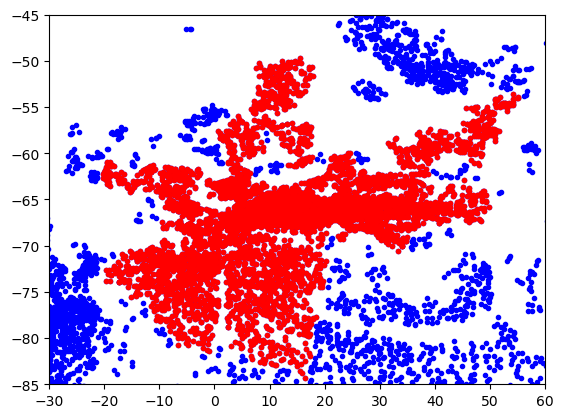

In [11]:
plt.plot(gdfE['lon'].values,gdfE['lat'].values,'.',color='blue')
plt.plot(gdfEsub['lon'].values,gdfEsub['lat'].values,'.',color='red')
plt.xlim((-30.,60.))
plt.ylim((-85.,-45.))
plt.show()

In [12]:
ob_sim = np.nan * np.ones(np.shape(compIDX))
ob_sim = optics_labels(gdfE['ob_idx'][compIDX],ob_uwd,ob_vwd)  # similarity-labels, from OPTICS clustering
print('{:d} observations reduced to {:d} clusters with {:d} singles'.format(np.size(compIDX),
                                                                            np.size(np.unique(ob_sim))-1,
                                                                            np.size(np.where(ob_sim==-1))))

6006 observations reduced to 72 clusters with 4558 singles


In [13]:
# remove (ob_sim == -1) observations from clustering search - these are unique (u,v) values with no
# similarity neighbors
gdfEsub = gdfEsub.assign(similGroup=ob_sim)
gdfEsub = gdfEsub.drop(index=gdfEsub.loc[gdfEsub['similGroup']==-1].index)
gdfEsub=gdfEsub.reset_index()
gdfEsub

,level_0,index,geometry,lat,lon,pre,tim,uob,vob,ob_idx,compGroup,similGroup
0,4,4,POINT (732482.241 -9122631.931),-81.949997,6.580000,412.0,-2.550000,-10.281547,13.159780,4,1,56
1,41,47,POINT (709105.144 -9054726.973),-81.339996,6.370000,350.0,-2.916667,-10.351218,13.736530,47,1,56
2,43,49,POINT (89055.594 -8049512.107),-72.309998,0.800000,512.0,-2.550000,-1.689492,10.667034,61,1,28
3,51,57,POINT (577748.164 -8486997.740),-76.239998,5.190000,350.0,-2.550000,-1.542657,17.632647,73,1,37
4,59,65,POINT (90168.788 -8051738.973),-72.330002,0.810000,512.0,-0.900000,0.188486,10.798355,82,1,29
...,...,...,...,...,...,...,...,...,...,...,...,...
1443,60403,62096,POINT (-857069.714 -6885533.712),-61.853802,-7.699188,550.0,-1.000000,-1.264794,12.033715,1822217,1,31
1444,60405,62098,POINT (-614672.609 -6919018.226),-62.154598,-5.521698,550.0,-1.000000,-0.897704,10.260805,1822222,1,40
1445,60410,62103,POINT (-593300.816 -7338236.683),-65.920502,-5.329712,487.0,-1.000000,-10.927389,13.022756,1822229,1,56
1446,60411,62104,POINT (-97458.910 -7528660.854),-67.631111,-0.875488,500.0,-1.000000,-5.128942,10.515890,1822231,1,27


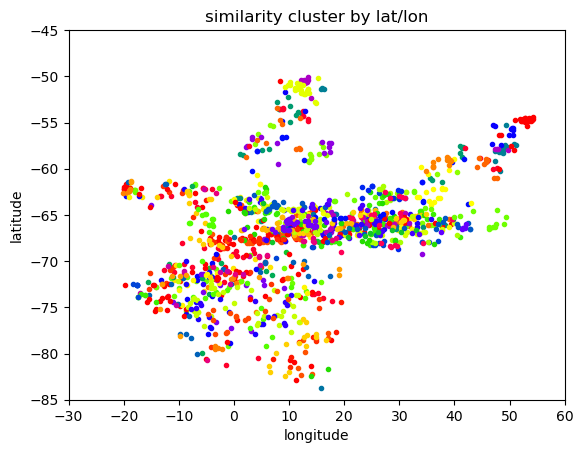

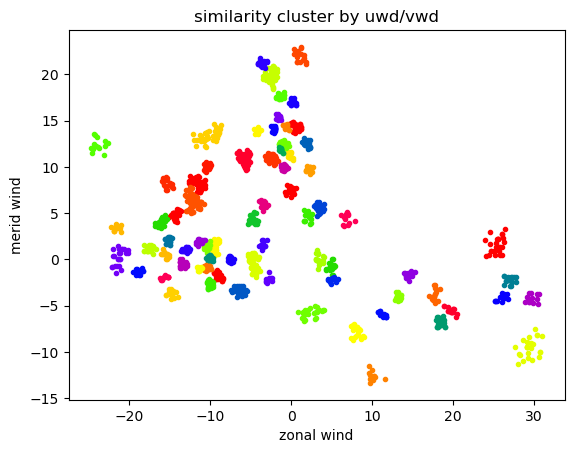

In [14]:
nClusters=np.size(np.unique(gdfEsub['similGroup'].values))
scalarMap = cm.ScalarMappable(cmap='prism')
scalarMapList = scalarMap.to_rgba(range(nClusters))
for c in range(nClusters):
    clu=np.unique(gdfEsub['similGroup'].values)[c]
    i=np.where(ob_sim==clu)
    if clu==-1:
        plt.plot(gdfEsub.loc[gdfEsub['similGroup']==clu,'lon'].values,
                 gdfEsub.loc[gdfEsub['similGroup']==clu,'lat'].values,
                 '.',
                 color='gray')
    else:
        pcol=list(scalarMapList[c][0:3])
        plt.plot(gdfEsub.loc[gdfEsub['similGroup']==clu,'lon'].values,
                 gdfEsub.loc[gdfEsub['similGroup']==clu,'lat'].values,
                 '.',
                 color=pcol)
        
plt.xlim((-30.,60.))
plt.ylim((-85.,-45.))
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('similarity cluster by lat/lon')
plt.show()


for c in range(nClusters):
    clu=np.unique(gdfEsub['similGroup'].values)[c]
    i=np.where(ob_sim==clu)
    if clu==-1:
        plt.plot(gdfEsub.loc[gdfEsub['similGroup']==clu,'uob'].values,
                 gdfEsub.loc[gdfEsub['similGroup']==clu,'vob'].values,
                 '.',
                 color='gray')
    else:
        pcol=list(scalarMapList[c][0:3])
        plt.plot(gdfEsub.loc[gdfEsub['similGroup']==clu,'uob'].values,
                 gdfEsub.loc[gdfEsub['similGroup']==clu,'vob'].values,
                 '.',
                 color=pcol)

plt.xlabel('zonal wind')
plt.ylabel('merid wind')
plt.title('similarity cluster by uwd/vwd')
plt.show()

In [15]:
# select a similaricy cluster
si = np.unique(gdfEsub['similGroup'].values)[0]
gdfEsubcl = gdfEsub.loc[gdfEsub['similGroup']==si]
gdfEsubcl

,level_0,index,geometry,lat,lon,pre,tim,uob,vob,ob_idx,compGroup,similGroup
124,628,635,POINT (69325.326 -7111808.123),-63.886459,0.622760,397.399994,-0.933333,-11.238186,7.298163,938,1,0
129,638,645,POINT (73999.629 -7113819.691),-63.904530,0.664750,395.200012,-0.933333,-11.238186,7.298163,951,1,0
130,639,646,POINT (101967.540 -7119754.177),-63.957840,0.915990,387.899994,-0.933333,-12.601371,8.499732,952,1,0
175,823,830,POINT (980671.255 -7544837.478),-67.776428,8.809520,498.600006,-2.483333,-11.795790,8.259501,1753,1,0
196,908,915,POINT (664123.173 -7514673.728),-67.505463,5.965920,428.000000,-1.616667,-10.646899,8.621690,1943,1,0
201,918,925,POINT (685243.839 -7551167.313),-67.833290,6.155650,438.299988,-1.616667,-11.523623,7.772781,1953,1,0
232,1050,1057,POINT (886443.773 -7454346.228),-66.963531,7.963060,426.500000,-0.783333,-12.412324,8.060658,2200,1,0
234,1064,1071,POINT (156190.150 -7512724.583),-67.487953,1.403080,413.700012,-0.783333,-12.369196,8.661004,2216,1,0
235,1065,1072,POINT (221899.825 -7524358.299),-67.592461,1.993360,430.000000,-0.783333,-12.458861,9.051893,2217,1,0
236,1077,1084,POINT (323013.539 -7551636.976),-67.837509,2.901680,431.600006,-0.783333,-11.703064,7.312886,2229,1,0


In [16]:
# w, iprox, jprox are keyed to 'level_0' in gdfEsub(cl) (the index value of gdfE)

In [17]:
iprox[np.where(np.isin(jprox,gdfEsubcl['level_0'].values[0]))]

array([407, 415, 416, 424, 425, 436, 437, 608, 609, 619, 620, 621, 627],
      dtype=int32)

In [18]:
i=4
print(gdfEsubcl.loc[gdfEsub['level_0']==gdfEsubcl['level_0'].values[i]])
gdfEsubcl.loc[gdfEsubcl['level_0'].isin(iprox[np.where(np.isin(jprox,gdfEsubcl['level_0'].values[i]))])]

     level_0  index                         geometry        lat      lon  \
196      908    915  POINT (664123.173 -7514673.728) -67.505463  5.96592   

       pre       tim        uob      vob  ob_idx  compGroup  similGroup  
196  428.0 -1.616667 -10.646899  8.62169    1943          1           0  


,level_0,index,geometry,lat,lon,pre,tim,uob,vob,ob_idx,compGroup,similGroup


In [19]:
i=4
proxidx=w.neighbors[gdfEsubcl['level_0'].values[i]]  # level_0 values of all proximity-neighbors
presidx=neighPresList[gdfEsubcl.index[i]]  # level_0 values of all pressure-neighbors
timeidx=neighTimeList[gdfEsubcl.index[i]]  # level_0 values of all time-neighbors
# show me the ob i'm clustering around
gdfEsubcl.iloc[i]

level_0                                               908
index                                                 915
geometry      POINT (664123.1733370235 -7514673.72757099)
lat                                            -67.505463
lon                                               5.96592
pre                                                 428.0
tim                                             -1.616667
uob                                            -10.646899
vob                                               8.62169
ob_idx                                               1943
compGroup                                               1
similGroup                                              0
Name: 196, dtype: object

In [20]:
# find that ob's 4d proximity neighbors
idx4d=np.intersect1d(timeidx,np.intersect1d(proxidx,presidx))
gdfEsubcl.loc[gdfEsubcl['level_0'].isin(idx4d)]

,level_0,index,geometry,lat,lon,pre,tim,uob,vob,ob_idx,compGroup,similGroup
201,918,925,POINT (685243.839 -7551167.313),-67.833290,6.15565,438.299988,-1.616667,-11.523623,7.772781,1953,1,0
237,1081,1088,POINT (634071.372 -7544873.148),-67.776749,5.69596,432.399994,-0.783333,-11.101033,8.365229,2233,1,0


In [21]:
# quick check with haversine, are these obs within 4d proximity range?
def haversine_np(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)

    All args must be of equal length.    

    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2

    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km

for j in range(len(gdfEsubcl.loc[gdfEsubcl['level_0'].isin(idx4d)])):
    d=haversine_np(gdfEsubcl.iloc[i]['lat'],
                   gdfEsubcl.iloc[i]['lon'],
                   gdfEsubcl.loc[gdfEsubcl['level_0'].isin(idx4d)]['lat'].values[j],
                   gdfEsubcl.loc[gdfEsubcl['level_0'].isin(idx4d)]['lon'].values[j])
    p=np.abs(gdfEsubcl.iloc[i]['pre']-gdfEsubcl.loc[gdfEsubcl['level_0'].isin(idx4d)]['pre'].values[j])
    t=np.abs(gdfEsubcl.iloc[i]['tim']-gdfEsubcl.loc[gdfEsubcl['level_0'].isin(idx4d)]['tim'].values[j])
    print(d<=0.001*distThreshold,p<=thresPres,t<=thresTime)

True True True
True True True


In [ ]:
# old stuff below

In [13]:
nClusters=np.size(np.unique(ob_sim))
scalarMap = cm.ScalarMappable(cmap='prism')
scalarMapList = scalarMap.to_rgba(range(nClusters))

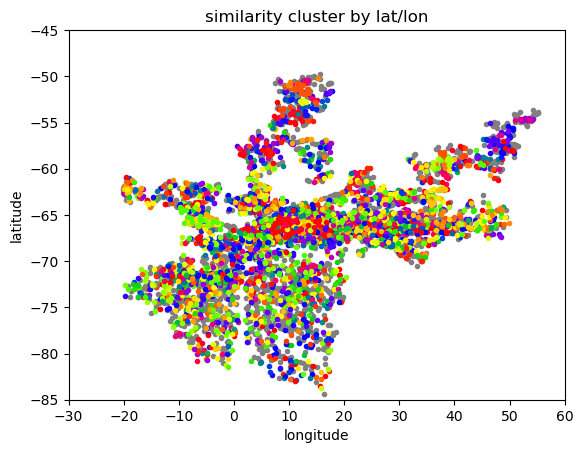

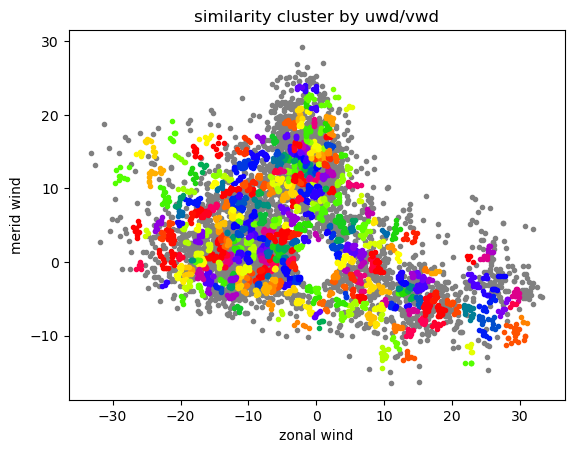

In [14]:
for c in range(nClusters):
    clu=np.unique(ob_sim)[c]
    i=np.where(ob_sim==clu)
    if clu==-1:
        plt.plot(ob_lon[gdfE['ob_idx'][compIDX[i]]],ob_lat[gdfE['ob_idx'][compIDX[i]]],'.',color='gray')
    else:
        pcol=list(scalarMapList[c][0:3])
        plt.plot(ob_lon[gdfE['ob_idx'][compIDX[i]]],ob_lat[gdfE['ob_idx'][compIDX[i]]],'.',color=pcol)
        
plt.xlim((-30.,60.))
plt.ylim((-85.,-45.))
plt.xlabel('longitude')
plt.ylabel('latitude')
plt.title('similarity cluster by lat/lon')
plt.show()


for c in range(nClusters):
    clu=np.unique(ob_sim)[c]
    i=np.where(ob_sim==clu)
    if clu==-1:
        plt.plot(ob_uwd[gdfE['ob_idx'][compIDX[i]]],ob_vwd[gdfE['ob_idx'][compIDX[i]]],'.',color='gray')
    else:
        pcol=list(scalarMapList[c][0:3])
        plt.plot(ob_uwd[gdfE['ob_idx'][compIDX[i]]],ob_vwd[gdfE['ob_idx'][compIDX[i]]],'.',color=pcol)
plt.xlabel('zonal wind')
plt.ylabel('merid wind')
plt.title('similarity cluster by uwd/vwd')
plt.show()

In [96]:
i=327
opClu=np.unique(ob_sim)[i]  # optics-cluster
print(opClu)
opCluMembers=np.where(ob_sim==opClu)[0]
print(opCluMembers)
print(iprox[np.where(np.isin(jprox,opCluMembers[1]))])
gdfE.iloc[iprox[np.where(np.isin(jprox,opCluMembers[1]))]]

326
[1074 2256 2257 2506 2970 3103 3104 3106 3136 3752 3917 3920 4216 4741
 4972 4975 4982 5009 5011 5012]
[1800 1953 1964 1965 1969 1970 1971 1972 1979 1980 1991 1992 2123 2124
 2142 2143 2153 2161 2162 2170 2171 2248 2249 2250 2255]


,index,geometry,lat,lon,pre,tim,uob,vob,ob_idx,compGroup
1800,1824,POINT (1342513.106 -7311464.189),-65.680000,12.06000,525.000000,-1.466667,-10.421735,1.279628e+00,38281,1
1953,1977,POINT (1404414.465 -7312131.739),-65.685997,12.61607,435.399994,-1.733333,-17.197380,3.001814e-01,38535,1
1964,1988,POINT (1343580.570 -7332278.841),-65.866982,12.06959,423.399994,-1.733333,-18.297213,3.193790e-01,38547,1
1965,1989,POINT (1353383.407 -7331418.500),-65.859253,12.15765,425.299988,-1.733333,-18.197227,3.176338e-01,38548,1
1969,1993,POINT (1255007.040 -7381594.313),-66.309990,11.27392,411.799988,-1.733333,-21.030174,-4.470101e+00,38554,1
1970,1994,POINT (1335300.635 -7385439.096),-66.344528,11.99521,414.899994,-1.733333,-18.163595,-2.230209e+00,38555,1
1971,1995,POINT (1390834.578 -7372187.463),-66.225487,12.49408,421.399994,-1.733333,-19.487402,4.499021e+00,38556,1
1972,1996,POINT (1423550.263 -7383964.711),-66.331284,12.78797,423.299988,-1.733333,-13.600000,-8.327598e-16,38557,1
1979,2003,POINT (1299511.438 -7407327.264),-66.541153,11.67371,413.200012,-1.733333,-16.972540,-2.083966e+00,38566,1
1980,2004,POINT (1309619.280 -7406492.401),-66.533653,11.76451,410.799988,-1.733333,-15.839496,-1.385776e+00,38567,1


In [86]:
gdfEsub.loc[gdfEsub['ob_idx']==39672]

,level_0,index,geometry,lat,lon,pre,tim,uob,vob,ob_idx,compGroup,similGroup
1262,2415,2439,POINT (1584396.914 -7623528.549),-68.483322,14.23288,454.200012,-2.483333,3.248224,5.859952,39672,1,326


In [95]:
gdfEsub.loc[gdfEsub['level_0'].isin(iprox[np.where(np.isin(jprox,opCluMembers[1]))])]

,level_0,index,geometry,lat,lon,pre,tim,uob,vob,ob_idx,compGroup,similGroup
1007,1953,1977,POINT (1404414.465 -7312131.739),-65.685997,12.61607,435.399994,-1.733333,-17.197380,0.300181,38535,1,273
1014,1964,1988,POINT (1343580.570 -7332278.841),-65.866982,12.06959,423.399994,-1.733333,-18.297213,0.319379,38547,1,278
1015,1965,1989,POINT (1353383.407 -7331418.500),-65.859253,12.15765,425.299988,-1.733333,-18.197227,0.317634,38548,1,278
1017,1971,1995,POINT (1390834.578 -7372187.463),-66.225487,12.49408,421.399994,-1.733333,-19.487402,4.499021,38556,1,269
1022,1979,2003,POINT (1299511.438 -7407327.264),-66.541153,11.67371,413.200012,-1.733333,-16.972540,-2.083966,38566,1,295
1023,1980,2004,POINT (1309619.280 -7406492.401),-66.533653,11.76451,410.799988,-1.733333,-15.839496,-1.385776,38567,1,240
1030,1991,2015,POINT (1300364.136 -7459761.366),-67.012177,11.68137,413.600006,-1.733333,-14.476584,3.077093,38578,1,202
1031,1992,2016,POINT (1402045.661 -7430128.429),-66.745979,12.59479,409.200012,-1.733333,-16.369417,3.779178,38579,1,220
1107,2142,2166,POINT (1262039.035 -7395691.849),-66.436630,11.33709,423.500000,-2.616667,-19.972187,6.489357,38841,1,430
1114,2153,2177,POINT (1390201.212 -7418532.083),-66.641808,12.48839,416.899994,-2.616667,-16.897427,-0.294946,38853,1,265


In [132]:
np.max(iprox)

60636

In [90]:
x=np.zeros((np.size(compIDX),np.size(compIDX)))
np.shape(x)

(6006, 6006)

In [119]:
iprox[np.where(jprox==compIDX[opCluMembers][0])]

array([354, 357, 364, 380, 571, 572, 843, 844, 858, 931], dtype=int32)

In [82]:
i=1
print('ob {:d} has {:d} proximity neightbors:'.format(gdfE['ob_idx'][compIDX[opCluMembers[i]]],np.size(np.where(jprox==compIDX[opCluMembers][i]))),
      gdfE['ob_idx'][iprox[np.where(jprox==compIDX[opCluMembers][i])]].values)
print(ob_lat[gdfE['ob_idx'][compIDX[opCluMembers[i]]]])
print(ob_lat[gdfE['ob_idx'][iprox[np.where(jprox==compIDX[opCluMembers][i])]]])

print(ob_lon[gdfE['ob_idx'][compIDX[opCluMembers[i]]]])
print(ob_lon[gdfE['ob_idx'][iprox[np.where(jprox==compIDX[opCluMembers][i])]]])

ob 39672 has 12 proximity neightbors: [38255 38628 38640 38641 38642 38652 38911 38912 38923 38945 39641 39654]
-68.48332
[-67.62    -67.78557 -67.9925  -67.92442 -67.98965 -68.44288 -67.78072
 -67.69506 -67.919   -68.55416 -67.60992 -67.65916]
14.23288
[14.06    14.1195  13.95218 14.46721 14.97287 14.04851 14.36922 14.46267
 14.71845 14.70216 14.35481 14.43831]


In [83]:
compIDX[opCluMembers][i]

2415

In [79]:
gdfE.loc[compIDX[opCluMembers][i]]

index                                                 2439
geometry     POINT (1584396.9138989046 -7623528.548852224)
lat                                             -68.483322
lon                                               14.23288
pre                                             454.200012
tim                                              -2.483333
uob                                               3.248224
vob                                               5.859952
ob_idx                                               39672
compGroup                                                1
Name: 2415, dtype: object

In [79]:
dfc = pd.DataFrame({'a': ['one', 'one', 'two',
                           'three', 'two', 'one', 'six'],
                     'c': np.arange(7)})


dfd = dfc.copy()

# Setting multiple items using a mask
mask = dfd['a'].str.startswith('o')

dfd.loc[mask, 'c'] = 42

dfd


,a,c
0,one,42
1,one,42
2,two,2
3,three,3
4,two,4
5,one,42
6,six,6


In [80]:
mask

0     True
1     True
2    False
3    False
4    False
5     True
6    False
Name: a, dtype: bool

In [102]:
gdfEsub = gdfE.loc[gdfE['compGroup']==ic]
# remove (ob_sim == -1) observations from clustering search - these are unique (u,v) values with no
# similarity neighbors
gdfEsub = gdfEsub.assign(similGroup=ob_sim)
gdfEsub = gdfEsub.drop(index=gdfEsub.loc[gdfEsub['similGroup']==-1].index)
gdfEsub=gdfEsub.reset_index()
gdfEsub

,level_0,index,geometry,lat,lon,pre,tim,ob_idx,compGroup,similGroup
0,2,2,POINT (921725.354 -9082556.846),-81.589996,8.280000,437.0,-2.55,2,1,289
1,4,4,POINT (732482.241 -9122631.931),-81.949997,6.580000,412.0,-2.55,4,1,433
2,5,5,POINT (765878.109 -9160480.999),-82.290001,6.880000,437.0,-2.55,5,1,137
3,6,6,POINT (982951.095 -9154914.685),-82.239998,8.830000,412.0,-2.55,6,1,5
4,8,8,POINT (1009667.748 -9203895.533),-82.680000,9.070000,437.0,-2.55,8,1,230
...,...,...,...,...,...,...,...,...,...,...
3381,60406,62099,POINT (-560025.230 -7045588.603),-63.291599,-5.030792,537.0,-1.00,1822224,1,12
3382,60407,62100,POINT (-448984.310 -7030360.223),-63.154800,-4.033295,550.0,-1.00,1822225,1,100
3383,60408,62101,POINT (-812077.180 -7165401.521),-64.367897,-7.295013,500.0,-1.00,1822226,1,308
3384,60410,62103,POINT (-593300.816 -7338236.683),-65.920502,-5.329712,487.0,-1.00,1822229,1,433


In [98]:
gdfEsub

,index,geometry,lat,lon,pre,tim,ob_idx,compGroup,similGroup
1,1,POINT (939536.456 -9013539.305),-80.970001,8.440000,450.0,-2.55,1,1,-1
2,2,POINT (921725.354 -9082556.846),-81.589996,8.280000,437.0,-2.55,2,1,289
4,4,POINT (732482.241 -9122631.931),-81.949997,6.580000,412.0,-2.55,4,1,433
5,5,POINT (765878.109 -9160480.999),-82.290001,6.880000,437.0,-2.55,5,1,137
6,6,POINT (982951.095 -9154914.685),-82.239998,8.830000,412.0,-2.55,6,1,5
...,...,...,...,...,...,...,...,...,...
60409,62102,POINT (-489570.673 -7269285.388),-65.301102,-4.397888,487.0,-1.00,1822227,1,-1
60410,62103,POINT (-593300.816 -7338236.683),-65.920502,-5.329712,487.0,-1.00,1822229,1,433
60411,62104,POINT (-97458.910 -7528660.854),-67.631111,-0.875488,500.0,-1.00,1822231,1,-1
60412,62105,POINT (-234984.411 -7602241.686),-68.292099,-2.110901,450.0,-1.00,1822232,1,55


In [93]:
len(ob_sim)

6006

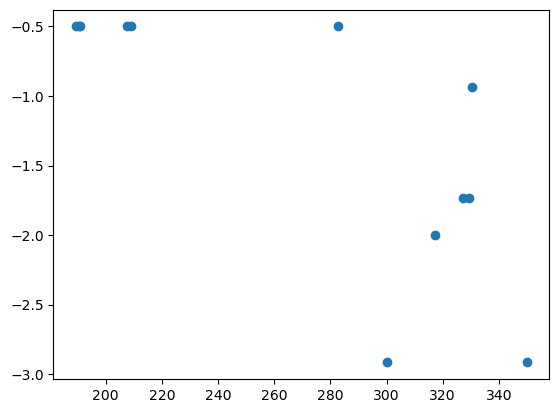

In [224]:
x=simidx[np.where(ob_sim[simidx]==ob_sim[simidx[compIDX[0]]])]
plt.plot(ob_pre[x],ob_tim[x],'o')
plt.show()

In [188]:
neighPresList

array([array([ 5881, 11205,  2536, ..., 33442, 70086, 62007]),
       array([ 35613,   1474,  52284, ...,  75555,  99354, 112394]),
       array([ 14667,   4841,   4659, ..., 115930, 115931, 115932]),
       array([ 1052,   931,   302, ..., 99045, 97524, 97762]),
       array([  2472,   2544,  13460, ..., 107754, 109988, 108427]),
       array([  2539,   5790,   6233, ...,  87726, 115023,  76416]),
       array([  1470,   2050,   6305, ..., 105776, 108648, 112348]),
       array([  4494,    448,   2528, ..., 115696,  98799, 107888]),
       array([  5710,  26403,  20800, ..., 115930, 115931, 115932]),
       array([  1797,   2624,  12358, ..., 115930, 115931, 115932]),
       array([ 8893, 22777, 12524, ..., 80106, 84995, 85138]),
       array([ 12961,  15990,   6917, ..., 109864, 112273, 112392]),
       array([  2261,   3243,   6407, ..., 115930, 115931, 115932]),
       array([ 4641,   979,   274, ..., 97548, 97808, 99048]),
       array([ 70567,  57610, 105982, ...,  99503,  97934,

In [190]:
neighTimeList

array([array([ 15095,  15096,  14758, ..., 115917, 115918, 115919]),
       array([ 15095,  15096,  14758, ..., 115917, 115918, 115919]),
       array([ 15095,  15096,  14758, ..., 115917, 115918, 115919]),
       array([    31,     19,     32, ..., 115865, 115864, 115876]),
       array([    20,     24,     23, ..., 115865, 115864, 115876]),
       array([ 15095,  15096,  14758, ..., 115917, 115918, 115919]),
       array([    20,     24,     23, ..., 115865, 115864, 115876]),
       array([    20,     24,     23, ..., 115865, 115864, 115876]),
       array([    20,     24,     23, ..., 115865, 115864, 115876]),
       array([    20,     24,     23, ..., 115865, 115864, 115876]),
       array([ 15095,  15096,  14758, ..., 115917, 115918, 115919]),
       array([ 15095,  15096,  14758, ..., 115917, 115918, 115919]),
       array([ 15095,  15096,  14758, ..., 115917, 115918, 115919]),
       array([ 15095,  15096,  14758, ..., 115917, 115918, 115919]),
       array([    31,     19,     

In [97]:
ob_clu = np.nan * np.ones(np.shape(ob_uwd))  # will contain genuineClusterIndex values for each observation
genClusIndex=0

# genuine clusters are defined by the following characteristics:
# 1. all obs are in same proximity-group
# 2. all obs are in same aff.prop. cluster
# 3. all obs are pressure-neighbors
# 4. all obs are time-neighbors
obList = list(compIDX)
while len(obList) > 0:
    # create a copy of obList that can be mutated without changing obList directly,
    # we will remove obs from this copy in-line and then assign obList to this
    # copy after mutations are over.
    obListCopy = obList.copy()
    #
    # select first ob in obList as a test-value to attach obs in cluster to
    #
    # proximity-group requirement is identified by all jprox values with a corresponding
    # iprox value of obList[0]
    proxIdx = jprox[np.where(iprox==obList[0])]
    # pressure-neighbor requirement is identified by all idx values in neighPres.radius_neighbors()
    presIdx = neighPres.radius_neighbors(np.reshape(ob_pre[obList[0]],(-1,1)),return_distance=False)[0]
    # time-neighbor requirement is identified by all idx values in neighTime.radius_neighbors()
    timeIdx = neighTime.radius_neighbors(np.reshape(ob_tim[obList[0]],(-1,1)),return_distance=False)[0]
    # find intersection of prox, pres, time
    spatTempIdx = np.intersect1d(proxIdx,np.intersect1d(presIdx,timeIdx))
    # if spatTempIdx.size > 0, perform affinity propagation on these obs with obList[0] to assign  
    # similarity-groups
    if spatTempIdx.size > 0:
        affProp = aff_prop_labels(np.append(obList[0],spatTempIdx),ob_uwd[idx],ob_vwd[idx])
        affPropSrc = affProp[0]
        affProp = affProp[1:]
        matchIdx = np.append(obList[0],spatTempIdx[np.where(affProp==affPropSrc)])
        matchIdx = np.intersect1d(matchIdx,obList)
    else:
        matchIdx = [obList[0]]
    # matchIdx should include obList[0], so it should never be np.size() < 1
    for mi in matchIdx:
        #  1. assign obList[mi] to genClusIndex
        #  2. remove obList[mi] from obListCopy,
        ob_clu[idx[mi]] = genClusIndex
        obListCopy.remove(mi)
    # assign obListCopy to obList, mutations complete
    obList = obListCopy
    print('{:d} observations remaining'.format(len(obList)))
    # increment genClusIndex for next cluster assignment
    genClusIndex = genClusIndex + 1

1849998

109914

In [36]:
presIdx = idx[neighPres.radius_neighbors(np.reshape(ob_pre[obList[0]],(-1,1)),return_distance=False)[0]]
timeIdx = idx[neighTime.radius_neighbors(np.reshape(ob_tim[obList[0]],(-1,1)),return_distance=False)[0]]

In [80]:
# start with a list of all observations in consideration
obList = list(np.arange(np.size(idx)))
ob_clu = np.nan * np.ones(np.shape(ob_uwd))  # will contain genuineClusterIndex values for each observation
genClusIndex=0

In [81]:
# genuine clusters are defined by the following characteristics:
# 1. all obs are in same proximity-group
# 2. all obs are in same aff.prop. cluster
# 3. all obs are pressure-neighbors
# 4. all obs are time-neighbors

while len(obList) > 0:
    # create a copy of obList that can be mutated without changing obList directly,
    # we will remove obs from this copy in-line and then assign obList to this
    # copy after mutations are over.
    obListCopy = obList.copy()
    #
    # select first ob in obList as a test-value to attach obs in cluster to
    #
    # proximity-group requirement is identified by all jprox values with a corresponding
    # iprox value of obList[0]
    proxIdx = jprox[np.where(iprox==obList[0])]
    # pressure-neighbor requirement is identified by all idx values in neighPres.radius_neighbors()
    presIdx = neighPres.radius_neighbors(np.reshape(ob_pre[obList[0]],(-1,1)),return_distance=False)[0]
    # time-neighbor requirement is identified by all idx values in neighTime.radius_neighbors()
    timeIdx = neighTime.radius_neighbors(np.reshape(ob_tim[obList[0]],(-1,1)),return_distance=False)[0]
    # find intersection of prox, pres, time
    spatTempIdx = np.intersect1d(proxIdx,np.intersect1d(presIdx,timeIdx))
    # if spatTempIdx.size > 0, perform affinity propagation on these obs with obList[0] to assign  
    # similarity-groups
    if spatTempIdx.size > 0:
        affProp = aff_prop_labels(np.append(obList[0],spatTempIdx),ob_uwd[idx],ob_vwd[idx])
        affPropSrc = affProp[0]
        affProp = affProp[1:]
        matchIdx = np.append(obList[0],spatTempIdx[np.where(affProp==affPropSrc)])
        matchIdx = np.intersect1d(matchIdx,obList)
    else:
        matchIdx = [obList[0]]
    # matchIdx should include obList[0], so it should never be np.size() < 1
    for mi in matchIdx:
        #  1. assign obList[mi] to genClusIndex
        #  2. remove obList[mi] from obListCopy,
        ob_clu[idx[mi]] = genClusIndex
        obListCopy.remove(mi)
    # assign obListCopy to obList, mutations complete
    obList = obListCopy
    print('{:d} observations remaining'.format(len(obList)))
    # increment genClusIndex for next cluster assignment
    genClusIndex = genClusIndex + 1

582777 observations remaining
582775 observations remaining
582774 observations remaining
582772 observations remaining
582771 observations remaining
582770 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


582768 observations remaining
582767 observations remaining
582766 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


582765 observations remaining
582763 observations remaining
582762 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


582761 observations remaining
582760 observations remaining
582759 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


582758 observations remaining
582757 observations remaining
582756 observations remaining
582755 observations remaining
582754 observations remaining
582753 observations remaining
582752 observations remaining
582751 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


582750 observations remaining
582749 observations remaining
582748 observations remaining
582747 observations remaining
582746 observations remaining
582745 observations remaining
582744 observations remaining
582743 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


582742 observations remaining
582741 observations remaining
582740 observations remaining
582739 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


582738 observations remaining
582737 observations remaining
582736 observations remaining
582733 observations remaining
582732 observations remaining
582731 observations remaining
582730 observations remaining
582729 observations remaining
582728 observations remaining
582727 observations remaining
582726 observations remaining
582725 observations remaining
582724 observations remaining
582723 observations remaining
582722 observations remaining
582721 observations remaining
582720 observations remaining
582719 observations remaining
582718 observations remaining
582716 observations remaining
582712 observations remaining
582711 observations remaining
582710 observations remaining
582709 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


582707 observations remaining
582698 observations remaining
582697 observations remaining
582693 observations remaining
582690 observations remaining
582687 observations remaining
582683 observations remaining
582680 observations remaining
582679 observations remaining
582677 observations remaining
582675 observations remaining
582674 observations remaining
582673 observations remaining
582672 observations remaining
582668 observations remaining
582667 observations remaining
582666 observations remaining
582663 observations remaining
582659 observations remaining
582655 observations remaining
582654 observations remaining
582649 observations remaining
582646 observations remaining
582643 observations remaining
582640 observations remaining
582639 observations remaining
582637 observations remaining
582634 observations remaining
582633 observations remaining
582632 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


582631 observations remaining
582629 observations remaining
582627 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


582626 observations remaining
582625 observations remaining
582624 observations remaining
582622 observations remaining
582619 observations remaining
582616 observations remaining
582615 observations remaining
582614 observations remaining
582613 observations remaining
582612 observations remaining
582609 observations remaining
582608 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


582607 observations remaining
582604 observations remaining
582603 observations remaining
582601 observations remaining
582600 observations remaining
582598 observations remaining
582597 observations remaining
582596 observations remaining
582591 observations remaining
582590 observations remaining
582589 observations remaining
582585 observations remaining
582584 observations remaining
582583 observations remaining
582581 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


582580 observations remaining
582579 observations remaining
582577 observations remaining
582575 observations remaining
582574 observations remaining
582571 observations remaining
582570 observations remaining
582569 observations remaining
582568 observations remaining
582566 observations remaining
582565 observations remaining
582561 observations remaining
582559 observations remaining
582558 observations remaining
582555 observations remaining
582554 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


582553 observations remaining
582552 observations remaining
582551 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


582550 observations remaining
582548 observations remaining
582546 observations remaining
582544 observations remaining
582541 observations remaining
582538 observations remaining
582536 observations remaining
582535 observations remaining
582534 observations remaining
582531 observations remaining
582529 observations remaining
582528 observations remaining
582527 observations remaining
582526 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


582524 observations remaining
582522 observations remaining
582521 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


582520 observations remaining
582519 observations remaining
582518 observations remaining
582517 observations remaining
582515 observations remaining
582514 observations remaining
582513 observations remaining
582512 observations remaining
582511 observations remaining
582510 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


582509 observations remaining
582508 observations remaining
582507 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


582506 observations remaining
582505 observations remaining
582502 observations remaining
582499 observations remaining
582497 observations remaining
582495 observations remaining
582493 observations remaining
582491 observations remaining
582490 observations remaining
582487 observations remaining
582485 observations remaining
582484 observations remaining
582482 observations remaining
582480 observations remaining
582479 observations remaining
582478 observations remaining
582477 observations remaining
582476 observations remaining
582475 observations remaining
582472 observations remaining
582471 observations remaining
582469 observations remaining
582467 observations remaining
582463 observations remaining
582462 observations remaining
582461 observations remaining
582459 observations remaining
582458 observations remaining
582457 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


582456 observations remaining
582453 observations remaining
582450 observations remaining
582449 observations remaining
582447 observations remaining
582445 observations remaining
582444 observations remaining
582443 observations remaining
582442 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


582441 observations remaining
582440 observations remaining
582439 observations remaining
582438 observations remaining
582437 observations remaining
582436 observations remaining
582434 observations remaining
582433 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


582432 observations remaining
582430 observations remaining
582429 observations remaining
582428 observations remaining
582427 observations remaining
582426 observations remaining
582425 observations remaining
582424 observations remaining
582420 observations remaining
582419 observations remaining
582418 observations remaining
582417 observations remaining
582416 observations remaining
582414 observations remaining
582413 observations remaining
582412 observations remaining
582411 observations remaining
582410 observations remaining
582409 observations remaining
582408 observations remaining
582407 observations remaining
582406 observations remaining
582405 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


582404 observations remaining
582403 observations remaining
582402 observations remaining
582401 observations remaining
582400 observations remaining
582399 observations remaining
582398 observations remaining
582391 observations remaining
582390 observations remaining
582389 observations remaining
582388 observations remaining
582387 observations remaining
582386 observations remaining
582385 observations remaining
582384 observations remaining
582383 observations remaining
582380 observations remaining
582379 observations remaining
582378 observations remaining
582376 observations remaining
582371 observations remaining
582367 observations remaining
582362 observations remaining
582361 observations remaining
582360 observations remaining
582359 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


582352 observations remaining
582350 observations remaining
582349 observations remaining
582347 observations remaining
582346 observations remaining
582345 observations remaining
582342 observations remaining
582333 observations remaining
582332 observations remaining
582331 observations remaining
582326 observations remaining
582325 observations remaining
582320 observations remaining
582318 observations remaining
582315 observations remaining
582309 observations remaining
582307 observations remaining
582306 observations remaining
582305 observations remaining
582304 observations remaining
582303 observations remaining
582301 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


582300 observations remaining
582299 observations remaining
582297 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


582296 observations remaining
582294 observations remaining
582288 observations remaining
582287 observations remaining
582283 observations remaining
582278 observations remaining
582275 observations remaining
582274 observations remaining
582264 observations remaining
582262 observations remaining
582261 observations remaining
582260 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


582259 observations remaining
582258 observations remaining
582256 observations remaining
582248 observations remaining
582240 observations remaining
582238 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


582237 observations remaining
582236 observations remaining
582235 observations remaining
582234 observations remaining
582233 observations remaining
582232 observations remaining
582231 observations remaining
582230 observations remaining
582229 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


582228 observations remaining
582227 observations remaining
582226 observations remaining
582225 observations remaining
582224 observations remaining
582223 observations remaining
582222 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


582221 observations remaining
582219 observations remaining
582216 observations remaining
582215 observations remaining
582211 observations remaining
582205 observations remaining
582203 observations remaining
582196 observations remaining
582194 observations remaining
582193 observations remaining
582187 observations remaining
582186 observations remaining
582185 observations remaining
582184 observations remaining
582183 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


582182 observations remaining
582180 observations remaining
582179 observations remaining
582177 observations remaining
582175 observations remaining
582172 observations remaining
582168 observations remaining
582167 observations remaining
582166 observations remaining
582163 observations remaining
582158 observations remaining
582154 observations remaining
582151 observations remaining
582150 observations remaining
582148 observations remaining
582145 observations remaining
582144 observations remaining
582138 observations remaining
582137 observations remaining
582135 observations remaining
582129 observations remaining
582121 observations remaining
582118 observations remaining
582117 observations remaining
582116 observations remaining
582115 observations remaining
582104 observations remaining
582095 observations remaining
582094 observations remaining
582091 observations remaining
582089 observations remaining
582086 observations remaining
582084 observations remaining
582083 obs

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


581969 observations remaining
581968 observations remaining
581967 observations remaining
581966 observations remaining
581965 observations remaining
581964 observations remaining
581963 observations remaining
581962 observations remaining
581961 observations remaining
581960 observations remaining
581959 observations remaining
581958 observations remaining
581957 observations remaining
581956 observations remaining
581955 observations remaining
581954 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


581950 observations remaining
581949 observations remaining
581941 observations remaining
581937 observations remaining
581931 observations remaining
581926 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


581925 observations remaining
581924 observations remaining
581918 observations remaining
581913 observations remaining
581908 observations remaining
581907 observations remaining
581904 observations remaining
581900 observations remaining
581899 observations remaining
581897 observations remaining
581889 observations remaining
581882 observations remaining
581870 observations remaining
581869 observations remaining
581868 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


581867 observations remaining
581866 observations remaining
581865 observations remaining
581861 observations remaining
581856 observations remaining
581855 observations remaining
581853 observations remaining
581852 observations remaining
581851 observations remaining
581849 observations remaining
581848 observations remaining
581847 observations remaining
581846 observations remaining
581844 observations remaining
581840 observations remaining
581839 observations remaining
581833 observations remaining
581832 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


581831 observations remaining
581828 observations remaining
581827 observations remaining
581825 observations remaining
581824 observations remaining
581820 observations remaining
581819 observations remaining
581809 observations remaining
581806 observations remaining
581802 observations remaining
581801 observations remaining
581799 observations remaining
581798 observations remaining
581792 observations remaining
581781 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


581780 observations remaining
581779 observations remaining
581774 observations remaining
581770 observations remaining
581768 observations remaining
581766 observations remaining
581765 observations remaining
581760 observations remaining
581757 observations remaining
581748 observations remaining
581745 observations remaining
581744 observations remaining
581741 observations remaining
581739 observations remaining
581738 observations remaining
581734 observations remaining
581733 observations remaining
581723 observations remaining
581720 observations remaining
581719 observations remaining
581718 observations remaining
581717 observations remaining
581716 observations remaining
581715 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


581714 observations remaining
581713 observations remaining
581700 observations remaining
581694 observations remaining
581685 observations remaining
581684 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


581683 observations remaining
581677 observations remaining
581669 observations remaining
581668 observations remaining
581667 observations remaining
581666 observations remaining
581665 observations remaining
581662 observations remaining
581659 observations remaining
581651 observations remaining
581645 observations remaining
581644 observations remaining
581642 observations remaining
581641 observations remaining
581633 observations remaining
581627 observations remaining
581616 observations remaining
581614 observations remaining
581607 observations remaining
581597 observations remaining
581596 observations remaining
581591 observations remaining
581588 observations remaining
581584 observations remaining
581583 observations remaining
581581 observations remaining
581580 observations remaining
581575 observations remaining
581573 observations remaining
581572 observations remaining
581571 observations remaining
581570 observations remaining
581566 observations remaining
581562 obs

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


581512 observations remaining
581511 observations remaining
581510 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


581509 observations remaining
581508 observations remaining
581507 observations remaining
581506 observations remaining
581505 observations remaining
581504 observations remaining
581503 observations remaining
581502 observations remaining
581501 observations remaining
581500 observations remaining
581497 observations remaining
581495 observations remaining
581494 observations remaining
581487 observations remaining
581486 observations remaining
581485 observations remaining
581484 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


581483 observations remaining
581482 observations remaining
581481 observations remaining
581480 observations remaining
581479 observations remaining
581478 observations remaining
581477 observations remaining
581476 observations remaining
581475 observations remaining
581474 observations remaining
581473 observations remaining
581469 observations remaining
581462 observations remaining
581452 observations remaining
581450 observations remaining
581449 observations remaining
581448 observations remaining
581447 observations remaining
581446 observations remaining
581445 observations remaining
581443 observations remaining
581442 observations remaining
581440 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


581439 observations remaining
581438 observations remaining
581437 observations remaining
581436 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


581435 observations remaining
581434 observations remaining
581433 observations remaining
581431 observations remaining
581428 observations remaining
581427 observations remaining
581426 observations remaining
581425 observations remaining
581424 observations remaining
581423 observations remaining
581419 observations remaining
581417 observations remaining
581416 observations remaining
581415 observations remaining
581414 observations remaining
581409 observations remaining
581401 observations remaining
581392 observations remaining
581386 observations remaining
581381 observations remaining
581378 observations remaining
581374 observations remaining
581373 observations remaining
581367 observations remaining
581366 observations remaining
581361 observations remaining
581357 observations remaining
581350 observations remaining
581343 observations remaining
581338 observations remaining
581334 observations remaining
581329 observations remaining
581328 observations remaining
581321 obs

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


581258 observations remaining
581257 observations remaining
581251 observations remaining
581246 observations remaining
581242 observations remaining
581239 observations remaining
581236 observations remaining
581235 observations remaining
581234 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


581225 observations remaining
581218 observations remaining
581213 observations remaining
581212 observations remaining
581211 observations remaining
581208 observations remaining
581206 observations remaining
581202 observations remaining
581201 observations remaining
581200 observations remaining
581198 observations remaining
581195 observations remaining
581193 observations remaining
581192 observations remaining
581187 observations remaining
581183 observations remaining
581181 observations remaining
581180 observations remaining
581176 observations remaining
581175 observations remaining
581174 observations remaining
581173 observations remaining
581171 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


581170 observations remaining
581166 observations remaining
581160 observations remaining
581157 observations remaining
581154 observations remaining
581151 observations remaining
581150 observations remaining
581146 observations remaining
581143 observations remaining
581142 observations remaining
581139 observations remaining
581135 observations remaining
581133 observations remaining
581131 observations remaining
581127 observations remaining
581125 observations remaining
581124 observations remaining
581119 observations remaining
581116 observations remaining
581114 observations remaining
581113 observations remaining
581112 observations remaining
581111 observations remaining
581110 observations remaining
581109 observations remaining
581108 observations remaining
581107 observations remaining
581106 observations remaining
581105 observations remaining
581104 observations remaining
581103 observations remaining
581102 observations remaining
581101 observations remaining
581100 obs

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


581094 observations remaining
581093 observations remaining
581092 observations remaining
581091 observations remaining
581090 observations remaining
581089 observations remaining
581088 observations remaining
581087 observations remaining
581086 observations remaining
581085 observations remaining
581084 observations remaining
581083 observations remaining
581082 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


581080 observations remaining
581079 observations remaining
581078 observations remaining
581076 observations remaining
581073 observations remaining
581065 observations remaining
581063 observations remaining
581061 observations remaining
581060 observations remaining
581054 observations remaining
581045 observations remaining
581044 observations remaining
581043 observations remaining
581041 observations remaining
581039 observations remaining
581036 observations remaining
581034 observations remaining
581032 observations remaining
581031 observations remaining
581026 observations remaining
581025 observations remaining
581024 observations remaining
581023 observations remaining
581021 observations remaining
581020 observations remaining
581019 observations remaining
581018 observations remaining
581017 observations remaining
581016 observations remaining
581015 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


581014 observations remaining
581013 observations remaining
581012 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


581011 observations remaining
581010 observations remaining
581009 observations remaining
581008 observations remaining
581007 observations remaining
581006 observations remaining
581004 observations remaining
581003 observations remaining
581002 observations remaining
581001 observations remaining
581000 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580999 observations remaining
580998 observations remaining
580996 observations remaining
580995 observations remaining
580994 observations remaining
580993 observations remaining
580992 observations remaining
580991 observations remaining
580990 observations remaining
580989 observations remaining
580988 observations remaining
580987 observations remaining
580986 observations remaining
580985 observations remaining
580984 observations remaining
580983 observations remaining
580982 observations remaining
580981 observations remaining
580980 observations remaining
580979 observations remaining
580978 observations remaining
580975 observations remaining
580974 observations remaining
580973 observations remaining
580972 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580971 observations remaining
580970 observations remaining
580969 observations remaining
580968 observations remaining
580967 observations remaining
580966 observations remaining
580965 observations remaining
580964 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580963 observations remaining
580962 observations remaining
580960 observations remaining
580959 observations remaining
580958 observations remaining
580957 observations remaining
580956 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580955 observations remaining
580954 observations remaining
580953 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580952 observations remaining
580951 observations remaining
580950 observations remaining
580949 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580948 observations remaining
580947 observations remaining
580946 observations remaining
580945 observations remaining
580944 observations remaining
580942 observations remaining
580941 observations remaining
580940 observations remaining
580939 observations remaining
580938 observations remaining
580937 observations remaining
580936 observations remaining
580933 observations remaining
580932 observations remaining
580931 observations remaining
580930 observations remaining
580929 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580928 observations remaining
580927 observations remaining
580926 observations remaining
580922 observations remaining
580919 observations remaining
580918 observations remaining
580917 observations remaining
580916 observations remaining
580915 observations remaining
580914 observations remaining
580912 observations remaining
580910 observations remaining
580909 observations remaining
580907 observations remaining
580906 observations remaining
580905 observations remaining
580904 observations remaining
580903 observations remaining
580902 observations remaining
580901 observations remaining
580900 observations remaining
580899 observations remaining
580898 observations remaining
580897 observations remaining
580895 observations remaining
580894 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580892 observations remaining
580891 observations remaining
580890 observations remaining
580888 observations remaining
580887 observations remaining
580884 observations remaining
580883 observations remaining
580882 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580881 observations remaining
580880 observations remaining
580878 observations remaining
580874 observations remaining
580873 observations remaining
580872 observations remaining
580870 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580869 observations remaining
580868 observations remaining
580867 observations remaining
580866 observations remaining
580865 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


580864 observations remaining
580862 observations remaining
580861 observations remaining
580860 observations remaining
580859 observations remaining
580858 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580857 observations remaining
580856 observations remaining
580855 observations remaining
580854 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580853 observations remaining
580852 observations remaining
580851 observations remaining
580850 observations remaining
580849 observations remaining
580848 observations remaining
580847 observations remaining
580846 observations remaining
580845 observations remaining
580844 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580843 observations remaining
580842 observations remaining
580841 observations remaining
580838 observations remaining
580837 observations remaining
580833 observations remaining
580832 observations remaining
580831 observations remaining
580830 observations remaining
580829 observations remaining
580828 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580827 observations remaining
580826 observations remaining
580825 observations remaining
580824 observations remaining
580823 observations remaining
580822 observations remaining
580821 observations remaining
580820 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580819 observations remaining
580818 observations remaining
580817 observations remaining
580816 observations remaining
580812 observations remaining
580811 observations remaining
580810 observations remaining
580809 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580808 observations remaining
580807 observations remaining
580806 observations remaining
580805 observations remaining
580804 observations remaining
580803 observations remaining
580802 observations remaining
580801 observations remaining
580800 observations remaining
580799 observations remaining
580798 observations remaining
580797 observations remaining
580796 observations remaining
580795 observations remaining
580794 observations remaining
580793 observations remaining
580792 observations remaining
580791 observations remaining
580789 observations remaining
580788 observations remaining
580787 observations remaining
580786 observations remaining
580785 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580784 observations remaining
580782 observations remaining
580781 observations remaining
580780 observations remaining
580779 observations remaining
580778 observations remaining
580777 observations remaining
580776 observations remaining
580775 observations remaining
580774 observations remaining
580773 observations remaining
580770 observations remaining
580769 observations remaining
580768 observations remaining
580767 observations remaining
580766 observations remaining
580765 observations remaining
580764 observations remaining
580763 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580762 observations remaining
580761 observations remaining
580760 observations remaining
580759 observations remaining
580758 observations remaining
580757 observations remaining
580756 observations remaining
580755 observations remaining
580754 observations remaining
580753 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580752 observations remaining
580751 observations remaining
580750 observations remaining
580749 observations remaining
580748 observations remaining
580747 observations remaining
580746 observations remaining
580745 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580744 observations remaining
580743 observations remaining
580742 observations remaining
580741 observations remaining
580740 observations remaining
580739 observations remaining
580738 observations remaining
580737 observations remaining
580736 observations remaining
580735 observations remaining
580734 observations remaining
580733 observations remaining
580732 observations remaining
580731 observations remaining
580729 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580728 observations remaining
580727 observations remaining
580726 observations remaining
580725 observations remaining
580724 observations remaining
580722 observations remaining
580721 observations remaining
580720 observations remaining
580719 observations remaining
580718 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580717 observations remaining
580716 observations remaining
580715 observations remaining
580714 observations remaining
580713 observations remaining
580712 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580711 observations remaining
580710 observations remaining
580708 observations remaining
580706 observations remaining
580705 observations remaining
580704 observations remaining
580702 observations remaining
580701 observations remaining
580700 observations remaining
580699 observations remaining
580698 observations remaining
580697 observations remaining
580696 observations remaining
580695 observations remaining
580694 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580693 observations remaining
580692 observations remaining
580691 observations remaining
580689 observations remaining
580688 observations remaining
580687 observations remaining
580686 observations remaining
580685 observations remaining
580684 observations remaining
580683 observations remaining
580682 observations remaining
580679 observations remaining
580678 observations remaining
580677 observations remaining
580676 observations remaining
580675 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580673 observations remaining
580672 observations remaining
580671 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580670 observations remaining
580669 observations remaining
580668 observations remaining
580667 observations remaining
580666 observations remaining
580663 observations remaining
580662 observations remaining
580661 observations remaining
580660 observations remaining
580657 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580656 observations remaining
580655 observations remaining
580654 observations remaining
580651 observations remaining
580650 observations remaining
580649 observations remaining
580648 observations remaining
580647 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580646 observations remaining
580645 observations remaining
580644 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580643 observations remaining
580642 observations remaining
580641 observations remaining
580640 observations remaining
580639 observations remaining
580638 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580637 observations remaining
580636 observations remaining
580634 observations remaining
580633 observations remaining
580632 observations remaining
580631 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580630 observations remaining
580629 observations remaining
580628 observations remaining
580627 observations remaining
580626 observations remaining
580625 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580624 observations remaining
580623 observations remaining
580622 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580621 observations remaining
580620 observations remaining
580619 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580618 observations remaining
580617 observations remaining
580616 observations remaining
580615 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580614 observations remaining
580612 observations remaining
580611 observations remaining
580610 observations remaining
580609 observations remaining
580608 observations remaining
580607 observations remaining
580606 observations remaining
580605 observations remaining
580604 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580602 observations remaining
580601 observations remaining
580600 observations remaining
580599 observations remaining
580598 observations remaining
580597 observations remaining
580596 observations remaining
580595 observations remaining
580594 observations remaining
580593 observations remaining
580592 observations remaining
580591 observations remaining
580590 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580589 observations remaining
580588 observations remaining
580587 observations remaining
580586 observations remaining
580585 observations remaining
580583 observations remaining
580579 observations remaining
580578 observations remaining
580577 observations remaining
580576 observations remaining
580575 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580574 observations remaining
580573 observations remaining
580572 observations remaining
580571 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580570 observations remaining
580569 observations remaining
580568 observations remaining
580567 observations remaining
580566 observations remaining
580565 observations remaining
580564 observations remaining
580563 observations remaining
580562 observations remaining
580561 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580560 observations remaining
580559 observations remaining
580558 observations remaining
580557 observations remaining
580556 observations remaining
580555 observations remaining
580554 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580553 observations remaining
580552 observations remaining
580551 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580549 observations remaining
580548 observations remaining
580547 observations remaining
580544 observations remaining
580543 observations remaining
580541 observations remaining
580539 observations remaining
580538 observations remaining
580534 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580529 observations remaining
580526 observations remaining
580523 observations remaining
580522 observations remaining
580521 observations remaining
580520 observations remaining
580517 observations remaining
580513 observations remaining
580511 observations remaining
580506 observations remaining
580504 observations remaining
580502 observations remaining
580501 observations remaining
580500 observations remaining
580498 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580496 observations remaining
580495 observations remaining
580494 observations remaining
580493 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580492 observations remaining
580491 observations remaining
580490 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580489 observations remaining
580488 observations remaining
580487 observations remaining
580486 observations remaining
580485 observations remaining
580484 observations remaining
580481 observations remaining
580480 observations remaining
580479 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580478 observations remaining
580477 observations remaining
580475 observations remaining
580474 observations remaining
580473 observations remaining
580472 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580469 observations remaining
580468 observations remaining
580467 observations remaining
580466 observations remaining
580465 observations remaining
580464 observations remaining
580463 observations remaining
580462 observations remaining
580461 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580460 observations remaining
580459 observations remaining
580458 observations remaining
580457 observations remaining
580454 observations remaining
580453 observations remaining
580452 observations remaining
580451 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580449 observations remaining
580448 observations remaining
580447 observations remaining
580444 observations remaining
580443 observations remaining
580442 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580441 observations remaining
580440 observations remaining
580439 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580438 observations remaining
580437 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580434 observations remaining
580433 observations remaining
580432 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580431 observations remaining
580430 observations remaining
580429 observations remaining
580428 observations remaining
580427 observations remaining
580426 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580422 observations remaining
580421 observations remaining
580419 observations remaining
580418 observations remaining
580417 observations remaining
580416 observations remaining
580415 observations remaining
580414 observations remaining
580410 observations remaining
580409 observations remaining
580408 observations remaining
580407 observations remaining
580406 observations remaining
580405 observations remaining
580404 observations remaining
580403 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580402 observations remaining
580401 observations remaining
580400 observations remaining
580399 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580398 observations remaining
580397 observations remaining
580396 observations remaining
580394 observations remaining
580393 observations remaining
580392 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580391 observations remaining
580390 observations remaining
580389 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580388 observations remaining
580387 observations remaining
580386 observations remaining
580385 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580384 observations remaining
580383 observations remaining
580382 observations remaining
580381 observations remaining
580380 observations remaining
580379 observations remaining
580375 observations remaining
580374 observations remaining
580373 observations remaining
580372 observations remaining
580371 observations remaining
580370 observations remaining
580369 observations remaining
580368 observations remaining
580367 observations remaining
580366 observations remaining
580365 observations remaining
580364 observations remaining
580363 observations remaining
580362 observations remaining
580361 observations remaining
580360 observations remaining
580359 observations remaining
580358 observations remaining
580357 observations remaining
580356 observations remaining
580355 observations remaining
580354 observations remaining
580353 observations remaining
580352 observations remaining
580351 observations remaining
580350 observations remaining
580349 observations remaining
580348 obs

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580317 observations remaining
580316 observations remaining
580315 observations remaining
580314 observations remaining
580313 observations remaining
580312 observations remaining
580311 observations remaining
580310 observations remaining
580309 observations remaining
580308 observations remaining
580307 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580306 observations remaining
580305 observations remaining
580304 observations remaining
580301 observations remaining
580300 observations remaining
580299 observations remaining
580298 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580295 observations remaining
580294 observations remaining
580293 observations remaining
580292 observations remaining
580291 observations remaining
580290 observations remaining
580289 observations remaining
580288 observations remaining
580287 observations remaining
580286 observations remaining
580285 observations remaining
580284 observations remaining
580283 observations remaining
580282 observations remaining
580281 observations remaining
580280 observations remaining
580279 observations remaining
580278 observations remaining
580276 observations remaining
580275 observations remaining
580274 observations remaining
580273 observations remaining
580272 observations remaining
580271 observations remaining
580270 observations remaining
580269 observations remaining
580268 observations remaining
580267 observations remaining
580266 observations remaining
580265 observations remaining
580264 observations remaining
580263 observations remaining
580262 observations remaining
580261 obs

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580248 observations remaining
580247 observations remaining
580246 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580245 observations remaining
580240 observations remaining
580234 observations remaining
580230 observations remaining
580229 observations remaining
580228 observations remaining
580222 observations remaining
580217 observations remaining
580216 observations remaining
580215 observations remaining
580214 observations remaining
580213 observations remaining
580210 observations remaining
580209 observations remaining
580208 observations remaining
580207 observations remaining
580206 observations remaining
580205 observations remaining
580204 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580203 observations remaining
580199 observations remaining
580195 observations remaining
580192 observations remaining
580191 observations remaining
580190 observations remaining
580189 observations remaining
580188 observations remaining
580187 observations remaining
580186 observations remaining
580185 observations remaining
580181 observations remaining
580179 observations remaining
580171 observations remaining
580168 observations remaining
580167 observations remaining
580160 observations remaining
580159 observations remaining
580157 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580156 observations remaining
580154 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580153 observations remaining
580152 observations remaining
580151 observations remaining
580148 observations remaining
580143 observations remaining
580142 observations remaining
580141 observations remaining
580140 observations remaining
580138 observations remaining
580136 observations remaining
580135 observations remaining
580134 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580133 observations remaining
580132 observations remaining
580131 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580130 observations remaining
580129 observations remaining
580128 observations remaining
580127 observations remaining
580126 observations remaining
580125 observations remaining
580124 observations remaining
580123 observations remaining
580122 observations remaining
580121 observations remaining
580120 observations remaining
580119 observations remaining
580118 observations remaining
580117 observations remaining
580116 observations remaining
580115 observations remaining
580114 observations remaining
580113 observations remaining
580112 observations remaining
580111 observations remaining
580110 observations remaining
580109 observations remaining
580108 observations remaining
580107 observations remaining
580104 observations remaining
580103 observations remaining
580102 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580100 observations remaining
580098 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


580097 observations remaining
580096 observations remaining
580095 observations remaining
580094 observations remaining
580092 observations remaining
580091 observations remaining
580089 observations remaining
580088 observations remaining
580087 observations remaining
580086 observations remaining
580085 observations remaining
580084 observations remaining
580082 observations remaining
580081 observations remaining
580078 observations remaining
580077 observations remaining
580076 observations remaining
580073 observations remaining
580072 observations remaining
580070 observations remaining
580069 observations remaining
580068 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580066 observations remaining
580065 observations remaining
580064 observations remaining
580063 observations remaining
580062 observations remaining
580059 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580055 observations remaining
580052 observations remaining
580051 observations remaining
580049 observations remaining
580048 observations remaining
580046 observations remaining
580045 observations remaining
580040 observations remaining
580037 observations remaining
580036 observations remaining
580035 observations remaining
580031 observations remaining
580028 observations remaining
580027 observations remaining
580026 observations remaining
580023 observations remaining
580022 observations remaining
580021 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580019 observations remaining
580018 observations remaining
580017 observations remaining
580015 observations remaining
580009 observations remaining
580008 observations remaining
580007 observations remaining
580006 observations remaining
580005 observations remaining
580004 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


580003 observations remaining
580002 observations remaining
580001 observations remaining
580000 observations remaining
579999 observations remaining
579998 observations remaining
579997 observations remaining
579996 observations remaining
579995 observations remaining
579994 observations remaining
579993 observations remaining
579992 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


579991 observations remaining
579990 observations remaining
579989 observations remaining
579988 observations remaining
579987 observations remaining
579985 observations remaining
579984 observations remaining
579983 observations remaining
579982 observations remaining
579981 observations remaining
579979 observations remaining
579978 observations remaining
579976 observations remaining
579975 observations remaining
579974 observations remaining
579973 observations remaining
579971 observations remaining
579970 observations remaining
579969 observations remaining
579964 observations remaining
579960 observations remaining
579959 observations remaining
579956 observations remaining
579954 observations remaining
579952 observations remaining
579949 observations remaining
579948 observations remaining
579947 observations remaining
579946 observations remaining
579945 observations remaining
579944 observations remaining
579943 observations remaining
579941 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


579940 observations remaining
579939 observations remaining
579938 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


579937 observations remaining
579936 observations remaining
579935 observations remaining
579933 observations remaining
579932 observations remaining
579929 observations remaining
579927 observations remaining
579925 observations remaining
579921 observations remaining
579918 observations remaining
579917 observations remaining
579916 observations remaining
579912 observations remaining
579911 observations remaining
579910 observations remaining
579909 observations remaining
579908 observations remaining
579907 observations remaining
579906 observations remaining
579905 observations remaining
579899 observations remaining
579898 observations remaining
579897 observations remaining
579896 observations remaining
579888 observations remaining
579887 observations remaining
579886 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


579885 observations remaining
579884 observations remaining
579883 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


579882 observations remaining
579881 observations remaining
579880 observations remaining
579879 observations remaining
579876 observations remaining
579875 observations remaining
579874 observations remaining
579872 observations remaining
579865 observations remaining
579864 observations remaining
579861 observations remaining
579860 observations remaining
579859 observations remaining
579857 observations remaining
579856 observations remaining
579849 observations remaining
579847 observations remaining
579843 observations remaining
579842 observations remaining
579841 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


579840 observations remaining
579839 observations remaining
579838 observations remaining
579836 observations remaining
579835 observations remaining
579834 observations remaining
579832 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


579831 observations remaining
579830 observations remaining
579829 observations remaining
579828 observations remaining
579827 observations remaining
579826 observations remaining
579825 observations remaining
579824 observations remaining
579823 observations remaining
579822 observations remaining
579821 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


579820 observations remaining
579819 observations remaining
579818 observations remaining
579817 observations remaining
579816 observations remaining
579811 observations remaining
579810 observations remaining
579809 observations remaining
579808 observations remaining
579807 observations remaining
579806 observations remaining
579805 observations remaining
579804 observations remaining
579802 observations remaining
579800 observations remaining
579799 observations remaining
579798 observations remaining
579797 observations remaining
579796 observations remaining
579795 observations remaining
579792 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


579788 observations remaining
579785 observations remaining
579782 observations remaining
579777 observations remaining
579776 observations remaining
579775 observations remaining
579772 observations remaining
579771 observations remaining
579765 observations remaining
579764 observations remaining
579760 observations remaining
579758 observations remaining
579754 observations remaining
579753 observations remaining
579752 observations remaining
579750 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


579745 observations remaining
579744 observations remaining
579743 observations remaining
579742 observations remaining
579741 observations remaining
579740 observations remaining
579739 observations remaining
579738 observations remaining
579737 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


579736 observations remaining
579731 observations remaining
579729 observations remaining
579726 observations remaining
579725 observations remaining
579724 observations remaining
579718 observations remaining
579717 observations remaining
579715 observations remaining
579713 observations remaining
579712 observations remaining
579711 observations remaining
579709 observations remaining
579708 observations remaining
579707 observations remaining
579706 observations remaining
579701 observations remaining
579697 observations remaining
579693 observations remaining
579692 observations remaining
579691 observations remaining
579690 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


579689 observations remaining
579688 observations remaining
579687 observations remaining
579685 observations remaining
579684 observations remaining
579683 observations remaining
579682 observations remaining
579681 observations remaining
579680 observations remaining
579679 observations remaining
579678 observations remaining
579677 observations remaining
579676 observations remaining
579675 observations remaining
579674 observations remaining
579673 observations remaining
579672 observations remaining
579671 observations remaining
579670 observations remaining
579669 observations remaining
579668 observations remaining
579667 observations remaining
579666 observations remaining
579665 observations remaining
579664 observations remaining
579663 observations remaining
579662 observations remaining
579661 observations remaining
579660 observations remaining
579659 observations remaining
579658 observations remaining
579657 observations remaining
579656 observations remaining
579655 obs

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


579621 observations remaining
579620 observations remaining
579619 observations remaining
579618 observations remaining
579617 observations remaining
579616 observations remaining
579615 observations remaining
579614 observations remaining
579613 observations remaining
579612 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


579611 observations remaining
579610 observations remaining
579609 observations remaining
579608 observations remaining
579607 observations remaining
579606 observations remaining
579605 observations remaining
579604 observations remaining
579603 observations remaining
579602 observations remaining
579601 observations remaining
579600 observations remaining
579599 observations remaining
579598 observations remaining
579597 observations remaining
579596 observations remaining
579595 observations remaining
579594 observations remaining
579593 observations remaining
579592 observations remaining
579591 observations remaining
579590 observations remaining
579589 observations remaining
579588 observations remaining
579587 observations remaining
579586 observations remaining
579585 observations remaining
579584 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


579583 observations remaining
579582 observations remaining
579581 observations remaining
579580 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


579579 observations remaining
579577 observations remaining
579576 observations remaining
579575 observations remaining
579574 observations remaining
579573 observations remaining
579572 observations remaining
579571 observations remaining
579570 observations remaining
579569 observations remaining
579568 observations remaining
579567 observations remaining
579566 observations remaining
579565 observations remaining
579564 observations remaining
579563 observations remaining
579562 observations remaining
579561 observations remaining
579560 observations remaining
579559 observations remaining
579558 observations remaining
579557 observations remaining
579556 observations remaining
579555 observations remaining
579554 observations remaining
579553 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


579552 observations remaining
579551 observations remaining
579550 observations remaining
579549 observations remaining
579548 observations remaining
579547 observations remaining
579546 observations remaining
579545 observations remaining
579544 observations remaining
579543 observations remaining
579542 observations remaining
579541 observations remaining
579540 observations remaining
579539 observations remaining
579538 observations remaining
579537 observations remaining
579536 observations remaining
579535 observations remaining
579534 observations remaining
579533 observations remaining
579532 observations remaining
579531 observations remaining
579530 observations remaining
579528 observations remaining
579527 observations remaining
579526 observations remaining
579525 observations remaining
579522 observations remaining
579521 observations remaining
579520 observations remaining
579519 observations remaining
579518 observations remaining
579517 observations remaining
579516 obs

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


579431 observations remaining
579430 observations remaining
579429 observations remaining
579428 observations remaining
579427 observations remaining
579426 observations remaining
579425 observations remaining
579417 observations remaining
579410 observations remaining
579406 observations remaining
579401 observations remaining
579400 observations remaining
579399 observations remaining
579398 observations remaining
579397 observations remaining
579396 observations remaining
579394 observations remaining
579393 observations remaining
579392 observations remaining
579391 observations remaining
579390 observations remaining
579389 observations remaining
579388 observations remaining
579387 observations remaining
579386 observations remaining
579385 observations remaining
579384 observations remaining
579383 observations remaining
579382 observations remaining
579381 observations remaining
579380 observations remaining
579379 observations remaining
579378 observations remaining
579377 obs

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


579373 observations remaining
579372 observations remaining
579371 observations remaining
579370 observations remaining
579369 observations remaining
579368 observations remaining
579367 observations remaining
579366 observations remaining
579365 observations remaining
579364 observations remaining
579363 observations remaining
579362 observations remaining
579361 observations remaining
579360 observations remaining
579359 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


579358 observations remaining
579357 observations remaining
579350 observations remaining
579348 observations remaining
579347 observations remaining
579346 observations remaining
579345 observations remaining
579343 observations remaining
579342 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


579341 observations remaining
579340 observations remaining
579339 observations remaining
579338 observations remaining
579337 observations remaining
579336 observations remaining
579335 observations remaining
579334 observations remaining
579333 observations remaining
579332 observations remaining
579331 observations remaining
579330 observations remaining
579329 observations remaining
579328 observations remaining
579327 observations remaining
579326 observations remaining
579325 observations remaining
579324 observations remaining
579323 observations remaining
579322 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


579321 observations remaining
579320 observations remaining
579319 observations remaining
579318 observations remaining
579317 observations remaining
579316 observations remaining
579315 observations remaining
579314 observations remaining
579313 observations remaining
579312 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


579311 observations remaining
579310 observations remaining
579309 observations remaining
579308 observations remaining
579307 observations remaining
579306 observations remaining
579305 observations remaining
579304 observations remaining
579303 observations remaining
579302 observations remaining
579301 observations remaining
579300 observations remaining
579299 observations remaining
579298 observations remaining
579297 observations remaining
579296 observations remaining
579295 observations remaining
579294 observations remaining
579293 observations remaining
579292 observations remaining
579291 observations remaining
579290 observations remaining
579289 observations remaining
579288 observations remaining
579287 observations remaining
579286 observations remaining
579285 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


579284 observations remaining
579283 observations remaining
579282 observations remaining
579281 observations remaining
579280 observations remaining
579279 observations remaining
579276 observations remaining
579275 observations remaining
579274 observations remaining
579273 observations remaining
579272 observations remaining
579271 observations remaining
579270 observations remaining
579269 observations remaining
579268 observations remaining
579267 observations remaining
579266 observations remaining
579265 observations remaining
579264 observations remaining
579263 observations remaining
579262 observations remaining
579261 observations remaining
579260 observations remaining
579259 observations remaining
579258 observations remaining
579257 observations remaining
579256 observations remaining
579255 observations remaining
579254 observations remaining
579253 observations remaining
579252 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


579251 observations remaining
579250 observations remaining
579249 observations remaining
579248 observations remaining
579247 observations remaining
579246 observations remaining
579245 observations remaining
579244 observations remaining
579243 observations remaining
579240 observations remaining
579239 observations remaining
579238 observations remaining
579237 observations remaining
579236 observations remaining
579235 observations remaining
579234 observations remaining
579233 observations remaining
579232 observations remaining
579231 observations remaining
579230 observations remaining
579229 observations remaining
579228 observations remaining
579227 observations remaining
579226 observations remaining
579225 observations remaining
579224 observations remaining
579223 observations remaining
579222 observations remaining
579221 observations remaining
579220 observations remaining
579219 observations remaining
579218 observations remaining
579217 observations remaining
579216 obs

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


579206 observations remaining
579205 observations remaining
579204 observations remaining
579203 observations remaining
579202 observations remaining
579201 observations remaining
579200 observations remaining
579199 observations remaining
579198 observations remaining
579197 observations remaining
579196 observations remaining
579195 observations remaining
579194 observations remaining
579193 observations remaining
579192 observations remaining
579191 observations remaining
579190 observations remaining
579189 observations remaining
579188 observations remaining
579187 observations remaining
579186 observations remaining
579185 observations remaining
579184 observations remaining
579183 observations remaining
579182 observations remaining
579181 observations remaining
579180 observations remaining
579179 observations remaining
579178 observations remaining
579177 observations remaining
579176 observations remaining
579175 observations remaining
579174 observations remaining
579173 obs

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


579146 observations remaining
579138 observations remaining
579137 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


579136 observations remaining
579135 observations remaining
579132 observations remaining
579131 observations remaining
579130 observations remaining
579129 observations remaining
579128 observations remaining
579127 observations remaining
579123 observations remaining
579118 observations remaining
579117 observations remaining
579116 observations remaining
579115 observations remaining
579114 observations remaining
579113 observations remaining
579112 observations remaining
579111 observations remaining
579110 observations remaining
579109 observations remaining
579108 observations remaining
579104 observations remaining
579103 observations remaining
579102 observations remaining
579101 observations remaining
579100 observations remaining
579099 observations remaining
579095 observations remaining
579094 observations remaining
579093 observations remaining
579090 observations remaining
579087 observations remaining
579080 observations remaining
579071 observations remaining
579067 obs

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


579035 observations remaining
579028 observations remaining
579022 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


579021 observations remaining
579018 observations remaining
579008 observations remaining
579005 observations remaining
579004 observations remaining
579003 observations remaining
579002 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


579001 observations remaining
579000 observations remaining
578999 observations remaining
578998 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


578997 observations remaining
578996 observations remaining
578995 observations remaining
578994 observations remaining
578993 observations remaining
578992 observations remaining
578991 observations remaining
578990 observations remaining
578989 observations remaining
578986 observations remaining
578983 observations remaining
578980 observations remaining
578977 observations remaining
578976 observations remaining
578973 observations remaining
578972 observations remaining
578970 observations remaining
578965 observations remaining
578961 observations remaining
578959 observations remaining
578958 observations remaining
578957 observations remaining
578956 observations remaining
578955 observations remaining
578954 observations remaining
578953 observations remaining
578952 observations remaining
578951 observations remaining
578950 observations remaining
578949 observations remaining
578948 observations remaining
578947 observations remaining
578946 observations remaining
578945 obs

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


578882 observations remaining
578880 observations remaining
578878 observations remaining
578876 observations remaining
578874 observations remaining
578872 observations remaining
578871 observations remaining
578870 observations remaining
578869 observations remaining
578868 observations remaining
578867 observations remaining
578866 observations remaining
578865 observations remaining
578864 observations remaining
578863 observations remaining
578862 observations remaining
578859 observations remaining
578858 observations remaining
578857 observations remaining
578856 observations remaining
578855 observations remaining
578852 observations remaining
578851 observations remaining
578850 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


578846 observations remaining
578842 observations remaining
578839 observations remaining
578836 observations remaining
578834 observations remaining
578833 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


578832 observations remaining
578831 observations remaining
578830 observations remaining
578829 observations remaining
578828 observations remaining
578827 observations remaining
578826 observations remaining
578825 observations remaining
578824 observations remaining
578823 observations remaining
578822 observations remaining
578821 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


578820 observations remaining
578819 observations remaining
578818 observations remaining
578816 observations remaining
578812 observations remaining
578807 observations remaining
578805 observations remaining
578803 observations remaining
578802 observations remaining
578798 observations remaining
578797 observations remaining
578795 observations remaining
578794 observations remaining
578793 observations remaining
578792 observations remaining
578791 observations remaining
578790 observations remaining
578789 observations remaining
578788 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


578787 observations remaining
578786 observations remaining
578785 observations remaining
578784 observations remaining
578783 observations remaining
578782 observations remaining
578781 observations remaining
578780 observations remaining
578779 observations remaining
578778 observations remaining
578777 observations remaining
578776 observations remaining
578774 observations remaining
578772 observations remaining
578770 observations remaining
578769 observations remaining
578768 observations remaining
578767 observations remaining
578766 observations remaining
578765 observations remaining
578764 observations remaining
578763 observations remaining
578762 observations remaining
578761 observations remaining
578760 observations remaining
578759 observations remaining
578758 observations remaining
578757 observations remaining
578756 observations remaining
578755 observations remaining
578754 observations remaining
578750 observations remaining
578749 observations remaining
578748 obs

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


578747 observations remaining
578746 observations remaining
578744 observations remaining
578742 observations remaining
578741 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


578740 observations remaining
578737 observations remaining
578735 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


578734 observations remaining
578729 observations remaining
578725 observations remaining
578724 observations remaining
578721 observations remaining
578720 observations remaining
578719 observations remaining
578718 observations remaining
578717 observations remaining
578716 observations remaining
578715 observations remaining
578714 observations remaining
578713 observations remaining
578712 observations remaining
578711 observations remaining
578710 observations remaining
578709 observations remaining
578708 observations remaining
578707 observations remaining
578706 observations remaining
578705 observations remaining
578703 observations remaining
578701 observations remaining
578699 observations remaining
578697 observations remaining
578696 observations remaining
578692 observations remaining
578689 observations remaining
578688 observations remaining
578681 observations remaining
578680 observations remaining
578679 observations remaining
578678 observations remaining
578677 obs

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


578663 observations remaining
578662 observations remaining
578661 observations remaining
578658 observations remaining
578655 observations remaining
578651 observations remaining
578647 observations remaining
578644 observations remaining
578640 observations remaining
578637 observations remaining
578636 observations remaining
578635 observations remaining
578634 observations remaining
578633 observations remaining
578632 observations remaining
578631 observations remaining
578630 observations remaining
578629 observations remaining
578628 observations remaining
578627 observations remaining
578626 observations remaining
578625 observations remaining
578624 observations remaining
578623 observations remaining
578622 observations remaining
578621 observations remaining
578620 observations remaining
578619 observations remaining
578618 observations remaining
578617 observations remaining
578615 observations remaining
578614 observations remaining
578613 observations remaining
578612 obs

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


578593 observations remaining
578592 observations remaining
578591 observations remaining
578590 observations remaining
578589 observations remaining
578588 observations remaining
578587 observations remaining
578586 observations remaining
578585 observations remaining
578584 observations remaining
578583 observations remaining
578582 observations remaining
578581 observations remaining
578580 observations remaining
578579 observations remaining
578578 observations remaining
578577 observations remaining
578576 observations remaining
578575 observations remaining
578574 observations remaining
578573 observations remaining
578572 observations remaining
578571 observations remaining
578570 observations remaining
578569 observations remaining
578568 observations remaining
578567 observations remaining
578566 observations remaining
578565 observations remaining
578563 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


578560 observations remaining
578557 observations remaining
578555 observations remaining
578551 observations remaining
578549 observations remaining
578548 observations remaining
578545 observations remaining
578542 observations remaining
578541 observations remaining
578540 observations remaining
578538 observations remaining
578537 observations remaining
578536 observations remaining
578535 observations remaining
578534 observations remaining
578533 observations remaining
578532 observations remaining
578531 observations remaining
578530 observations remaining
578529 observations remaining
578528 observations remaining
578527 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


578526 observations remaining
578525 observations remaining
578524 observations remaining
578523 observations remaining
578522 observations remaining
578521 observations remaining
578520 observations remaining
578519 observations remaining
578518 observations remaining
578517 observations remaining
578516 observations remaining
578515 observations remaining
578514 observations remaining
578513 observations remaining
578512 observations remaining
578511 observations remaining
578510 observations remaining
578508 observations remaining
578507 observations remaining
578506 observations remaining
578505 observations remaining
578504 observations remaining
578503 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


578502 observations remaining
578501 observations remaining
578500 observations remaining
578499 observations remaining
578498 observations remaining
578497 observations remaining
578496 observations remaining
578495 observations remaining
578494 observations remaining
578493 observations remaining
578492 observations remaining
578491 observations remaining
578490 observations remaining
578489 observations remaining
578488 observations remaining
578487 observations remaining
578486 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


578485 observations remaining
578484 observations remaining
578483 observations remaining
578482 observations remaining
578481 observations remaining
578480 observations remaining
578479 observations remaining
578478 observations remaining
578477 observations remaining
578476 observations remaining
578475 observations remaining
578474 observations remaining
578473 observations remaining
578472 observations remaining
578471 observations remaining
578470 observations remaining
578469 observations remaining
578468 observations remaining
578467 observations remaining
578466 observations remaining
578465 observations remaining
578464 observations remaining
578463 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


578462 observations remaining
578461 observations remaining
578460 observations remaining
578459 observations remaining
578458 observations remaining
578457 observations remaining
578456 observations remaining
578455 observations remaining
578454 observations remaining
578453 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


578452 observations remaining
578451 observations remaining
578450 observations remaining
578449 observations remaining
578448 observations remaining
578447 observations remaining
578446 observations remaining
578444 observations remaining
578443 observations remaining
578442 observations remaining
578441 observations remaining
578440 observations remaining
578439 observations remaining
578438 observations remaining
578437 observations remaining
578436 observations remaining
578435 observations remaining
578434 observations remaining
578433 observations remaining
578432 observations remaining
578431 observations remaining
578430 observations remaining
578429 observations remaining
578428 observations remaining
578427 observations remaining
578426 observations remaining
578425 observations remaining
578424 observations remaining
578423 observations remaining
578422 observations remaining
578421 observations remaining
578420 observations remaining
578419 observations remaining
578418 obs

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


578378 observations remaining
578377 observations remaining
578376 observations remaining
578374 observations remaining
578373 observations remaining
578372 observations remaining
578371 observations remaining
578370 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


578368 observations remaining
578367 observations remaining
578366 observations remaining
578365 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


578364 observations remaining
578363 observations remaining
578362 observations remaining
578361 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


578359 observations remaining
578358 observations remaining
578357 observations remaining
578356 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


578355 observations remaining
578354 observations remaining
578353 observations remaining
578352 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


578351 observations remaining
578350 observations remaining
578349 observations remaining
578348 observations remaining
578347 observations remaining
578346 observations remaining
578345 observations remaining
578344 observations remaining
578343 observations remaining
578342 observations remaining
578341 observations remaining
578340 observations remaining
578339 observations remaining
578338 observations remaining
578337 observations remaining
578336 observations remaining
578335 observations remaining
578334 observations remaining
578333 observations remaining
578332 observations remaining
578331 observations remaining
578330 observations remaining
578329 observations remaining
578328 observations remaining
578327 observations remaining
578326 observations remaining
578325 observations remaining
578324 observations remaining
578323 observations remaining
578322 observations remaining
578321 observations remaining
578320 observations remaining
578319 observations remaining
578318 obs

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


578311 observations remaining
578310 observations remaining
578309 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


578308 observations remaining
578307 observations remaining
578306 observations remaining
578305 observations remaining
578304 observations remaining
578303 observations remaining
578302 observations remaining
578301 observations remaining
578300 observations remaining
578299 observations remaining
578298 observations remaining
578297 observations remaining
578296 observations remaining
578295 observations remaining
578294 observations remaining
578293 observations remaining
578292 observations remaining
578291 observations remaining
578290 observations remaining
578289 observations remaining
578288 observations remaining
578287 observations remaining
578286 observations remaining
578285 observations remaining
578284 observations remaining
578283 observations remaining
578282 observations remaining
578281 observations remaining
578280 observations remaining
578279 observations remaining
578278 observations remaining
578277 observations remaining
578276 observations remaining
578275 obs

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


578254 observations remaining
578253 observations remaining
578252 observations remaining
578251 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


578250 observations remaining
578249 observations remaining
578248 observations remaining
578247 observations remaining
578246 observations remaining
578245 observations remaining
578244 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


578243 observations remaining
578242 observations remaining
578241 observations remaining
578240 observations remaining
578239 observations remaining
578238 observations remaining
578237 observations remaining
578236 observations remaining
578235 observations remaining
578234 observations remaining
578233 observations remaining
578232 observations remaining
578231 observations remaining
578230 observations remaining
578229 observations remaining
578228 observations remaining
578227 observations remaining
578225 observations remaining
578224 observations remaining
578223 observations remaining
578222 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


578219 observations remaining
578218 observations remaining
578217 observations remaining
578216 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


578215 observations remaining
578214 observations remaining
578212 observations remaining
578211 observations remaining
578210 observations remaining
578209 observations remaining
578208 observations remaining
578207 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


578206 observations remaining
578203 observations remaining
578200 observations remaining
578199 observations remaining
578198 observations remaining
578193 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


578192 observations remaining
578190 observations remaining
578189 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


578188 observations remaining
578187 observations remaining
578186 observations remaining
578185 observations remaining
578184 observations remaining
578181 observations remaining
578180 observations remaining
578179 observations remaining
578178 observations remaining
578177 observations remaining
578176 observations remaining
578175 observations remaining
578174 observations remaining
578173 observations remaining
578172 observations remaining
578171 observations remaining
578170 observations remaining
578167 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


578166 observations remaining
578165 observations remaining
578164 observations remaining
578163 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


578162 observations remaining
578161 observations remaining
578159 observations remaining
578158 observations remaining
578156 observations remaining
578155 observations remaining
578154 observations remaining
578153 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


578152 observations remaining
578151 observations remaining
578150 observations remaining
578148 observations remaining
578147 observations remaining
578146 observations remaining
578145 observations remaining
578144 observations remaining
578143 observations remaining
578142 observations remaining
578141 observations remaining
578140 observations remaining
578139 observations remaining
578138 observations remaining
578137 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


578136 observations remaining
578135 observations remaining
578134 observations remaining
578133 observations remaining
578132 observations remaining
578131 observations remaining
578130 observations remaining
578129 observations remaining
578128 observations remaining
578127 observations remaining
578126 observations remaining
578125 observations remaining
578124 observations remaining
578123 observations remaining
578122 observations remaining
578121 observations remaining
578120 observations remaining
578119 observations remaining
578118 observations remaining
578117 observations remaining
578116 observations remaining
578115 observations remaining
578114 observations remaining
578113 observations remaining
578112 observations remaining
578111 observations remaining
578110 observations remaining
578109 observations remaining
578108 observations remaining
578107 observations remaining
578106 observations remaining
578105 observations remaining
578104 observations remaining
578103 obs

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


578058 observations remaining
578056 observations remaining
578055 observations remaining
578054 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


578053 observations remaining
578051 observations remaining
578050 observations remaining
578049 observations remaining
578048 observations remaining
578047 observations remaining
578046 observations remaining
578045 observations remaining
578044 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


578043 observations remaining
578042 observations remaining
578040 observations remaining
578039 observations remaining
578038 observations remaining
578037 observations remaining
578036 observations remaining
578035 observations remaining
578034 observations remaining
578033 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


578032 observations remaining
578031 observations remaining
578030 observations remaining
578027 observations remaining
578026 observations remaining
578025 observations remaining
578024 observations remaining
578023 observations remaining
578022 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


578021 observations remaining
578020 observations remaining
578019 observations remaining
578018 observations remaining
578017 observations remaining
578015 observations remaining
578014 observations remaining
578013 observations remaining
578012 observations remaining
578011 observations remaining
578010 observations remaining
578009 observations remaining
578008 observations remaining
578007 observations remaining
578006 observations remaining
578005 observations remaining
578004 observations remaining
578003 observations remaining
578002 observations remaining
578001 observations remaining
578000 observations remaining
577999 observations remaining
577998 observations remaining
577997 observations remaining
577996 observations remaining
577995 observations remaining
577994 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


577993 observations remaining
577992 observations remaining
577991 observations remaining
577990 observations remaining
577989 observations remaining
577988 observations remaining
577987 observations remaining
577986 observations remaining
577985 observations remaining
577984 observations remaining
577983 observations remaining
577982 observations remaining
577980 observations remaining
577979 observations remaining
577978 observations remaining
577977 observations remaining
577976 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


577975 observations remaining
577974 observations remaining
577973 observations remaining
577972 observations remaining
577971 observations remaining
577970 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


577969 observations remaining
577968 observations remaining
577967 observations remaining
577966 observations remaining
577965 observations remaining
577964 observations remaining
577963 observations remaining
577962 observations remaining
577961 observations remaining
577960 observations remaining
577959 observations remaining
577958 observations remaining
577957 observations remaining
577956 observations remaining
577955 observations remaining
577954 observations remaining
577953 observations remaining
577952 observations remaining
577951 observations remaining
577950 observations remaining
577949 observations remaining
577948 observations remaining
577947 observations remaining
577946 observations remaining
577945 observations remaining
577944 observations remaining
577943 observations remaining
577942 observations remaining
577941 observations remaining
577940 observations remaining
577939 observations remaining
577938 observations remaining
577937 observations remaining
577936 obs

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


577903 observations remaining
577902 observations remaining
577899 observations remaining
577897 observations remaining
577892 observations remaining
577890 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


577889 observations remaining
577888 observations remaining
577887 observations remaining
577885 observations remaining
577884 observations remaining
577883 observations remaining
577882 observations remaining
577881 observations remaining
577880 observations remaining
577879 observations remaining
577875 observations remaining
577874 observations remaining
577873 observations remaining
577872 observations remaining
577871 observations remaining
577869 observations remaining
577868 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


577867 observations remaining
577866 observations remaining
577865 observations remaining
577864 observations remaining
577863 observations remaining
577862 observations remaining
577860 observations remaining
577857 observations remaining
577856 observations remaining
577855 observations remaining
577854 observations remaining
577851 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


577850 observations remaining
577848 observations remaining
577847 observations remaining
577846 observations remaining
577845 observations remaining
577844 observations remaining
577843 observations remaining
577842 observations remaining
577841 observations remaining
577840 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


577839 observations remaining
577838 observations remaining
577837 observations remaining
577836 observations remaining
577835 observations remaining
577834 observations remaining
577833 observations remaining
577832 observations remaining
577831 observations remaining
577830 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


577829 observations remaining
577828 observations remaining
577827 observations remaining
577824 observations remaining
577823 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


577822 observations remaining
577821 observations remaining
577820 observations remaining
577819 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


577818 observations remaining
577817 observations remaining
577816 observations remaining
577815 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


577814 observations remaining
577813 observations remaining
577812 observations remaining
577811 observations remaining
577810 observations remaining
577809 observations remaining
577808 observations remaining
577807 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


577806 observations remaining
577805 observations remaining
577804 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


577803 observations remaining
577802 observations remaining
577801 observations remaining
577800 observations remaining
577799 observations remaining
577796 observations remaining
577795 observations remaining
577794 observations remaining
577793 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


577792 observations remaining
577791 observations remaining
577790 observations remaining
577789 observations remaining
577788 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


577787 observations remaining
577786 observations remaining
577785 observations remaining
577784 observations remaining
577783 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


577782 observations remaining
577781 observations remaining
577780 observations remaining
577779 observations remaining
577778 observations remaining
577777 observations remaining
577776 observations remaining
577775 observations remaining
577774 observations remaining
577773 observations remaining
577772 observations remaining
577771 observations remaining
577770 observations remaining
577769 observations remaining
577768 observations remaining
577767 observations remaining
577766 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


577765 observations remaining
577764 observations remaining
577763 observations remaining
577762 observations remaining
577761 observations remaining
577760 observations remaining
577759 observations remaining
577758 observations remaining
577757 observations remaining
577756 observations remaining
577755 observations remaining
577754 observations remaining
577753 observations remaining
577752 observations remaining
577751 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


577750 observations remaining
577749 observations remaining
577748 observations remaining
577747 observations remaining
577746 observations remaining
577745 observations remaining
577744 observations remaining
577743 observations remaining
577742 observations remaining
577741 observations remaining
577740 observations remaining
577739 observations remaining
577738 observations remaining
577737 observations remaining
577736 observations remaining
577735 observations remaining
577734 observations remaining
577733 observations remaining
577732 observations remaining
577731 observations remaining
577730 observations remaining
577729 observations remaining
577728 observations remaining
577727 observations remaining
577726 observations remaining
577725 observations remaining
577724 observations remaining
577723 observations remaining
577722 observations remaining
577721 observations remaining
577720 observations remaining
577719 observations remaining
577718 observations remaining
577717 obs

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


577550 observations remaining
577549 observations remaining
577548 observations remaining
577547 observations remaining
577546 observations remaining
577545 observations remaining
577544 observations remaining
577543 observations remaining
577542 observations remaining
577541 observations remaining
577540 observations remaining
577539 observations remaining
577538 observations remaining
577537 observations remaining
577536 observations remaining
577535 observations remaining
577534 observations remaining
577533 observations remaining
577532 observations remaining
577531 observations remaining
577530 observations remaining
577529 observations remaining
577528 observations remaining
577527 observations remaining
577526 observations remaining
577525 observations remaining
577524 observations remaining
577523 observations remaining
577522 observations remaining
577521 observations remaining
577520 observations remaining
577519 observations remaining
577518 observations remaining
577517 obs

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


577437 observations remaining
577436 observations remaining
577435 observations remaining
577434 observations remaining
577433 observations remaining
577430 observations remaining
577429 observations remaining
577428 observations remaining
577427 observations remaining
577426 observations remaining
577425 observations remaining
577424 observations remaining
577423 observations remaining
577422 observations remaining
577421 observations remaining
577420 observations remaining
577419 observations remaining
577418 observations remaining
577417 observations remaining
577416 observations remaining
577415 observations remaining
577414 observations remaining
577413 observations remaining
577412 observations remaining
577411 observations remaining
577410 observations remaining
577409 observations remaining
577408 observations remaining
577407 observations remaining
577406 observations remaining
577405 observations remaining
577404 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


577403 observations remaining
577402 observations remaining
577401 observations remaining
577400 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


577399 observations remaining
577398 observations remaining
577397 observations remaining
577396 observations remaining
577395 observations remaining
577394 observations remaining
577393 observations remaining
577392 observations remaining
577391 observations remaining
577390 observations remaining
577389 observations remaining
577388 observations remaining
577387 observations remaining
577386 observations remaining
577385 observations remaining
577384 observations remaining
577383 observations remaining
577382 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


577381 observations remaining
577373 observations remaining
577372 observations remaining
577371 observations remaining
577370 observations remaining
577369 observations remaining
577368 observations remaining
577367 observations remaining
577366 observations remaining
577365 observations remaining
577357 observations remaining
577356 observations remaining
577355 observations remaining
577354 observations remaining
577353 observations remaining
577352 observations remaining
577351 observations remaining
577350 observations remaining
577349 observations remaining
577348 observations remaining
577347 observations remaining
577346 observations remaining
577340 observations remaining
577339 observations remaining
577336 observations remaining
577333 observations remaining
577332 observations remaining
577331 observations remaining
577330 observations remaining
577329 observations remaining
577328 observations remaining
577327 observations remaining
577326 observations remaining
577325 obs

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


577322 observations remaining
577321 observations remaining
577320 observations remaining
577319 observations remaining
577318 observations remaining
577317 observations remaining
577316 observations remaining
577315 observations remaining
577314 observations remaining
577313 observations remaining
577312 observations remaining
577311 observations remaining
577310 observations remaining
577309 observations remaining
577308 observations remaining
577307 observations remaining
577306 observations remaining
577305 observations remaining
577304 observations remaining
577303 observations remaining
577302 observations remaining
577298 observations remaining
577297 observations remaining
577295 observations remaining
577294 observations remaining
577293 observations remaining
577292 observations remaining
577291 observations remaining
577288 observations remaining
577287 observations remaining
577286 observations remaining
577285 observations remaining
577284 observations remaining
577283 obs

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


577267 observations remaining
577266 observations remaining
577265 observations remaining
577264 observations remaining
577263 observations remaining
577262 observations remaining
577261 observations remaining
577260 observations remaining
577259 observations remaining
577258 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


577257 observations remaining
577256 observations remaining
577255 observations remaining
577254 observations remaining
577253 observations remaining
577252 observations remaining
577251 observations remaining
577250 observations remaining
577249 observations remaining
577248 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


577247 observations remaining
577246 observations remaining
577245 observations remaining
577244 observations remaining
577243 observations remaining
577242 observations remaining
577233 observations remaining
577232 observations remaining
577231 observations remaining
577230 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


577229 observations remaining
577228 observations remaining
577227 observations remaining
577226 observations remaining
577225 observations remaining
577224 observations remaining
577223 observations remaining
577222 observations remaining
577221 observations remaining
577220 observations remaining
577219 observations remaining
577218 observations remaining
577217 observations remaining
577216 observations remaining
577215 observations remaining
577214 observations remaining
577213 observations remaining
577212 observations remaining
577211 observations remaining
577210 observations remaining
577209 observations remaining
577208 observations remaining
577207 observations remaining
577206 observations remaining
577205 observations remaining
577204 observations remaining
577203 observations remaining
577202 observations remaining
577201 observations remaining
577200 observations remaining
577199 observations remaining
577198 observations remaining
577197 observations remaining
577196 obs

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


577165 observations remaining
577164 observations remaining
577163 observations remaining
577162 observations remaining
577161 observations remaining
577160 observations remaining
577158 observations remaining
577157 observations remaining
577156 observations remaining
577155 observations remaining
577154 observations remaining
577153 observations remaining
577152 observations remaining
577151 observations remaining
577150 observations remaining
577149 observations remaining
577148 observations remaining
577147 observations remaining
577146 observations remaining
577145 observations remaining
577144 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


577143 observations remaining
577142 observations remaining
577141 observations remaining
577140 observations remaining
577139 observations remaining
577138 observations remaining
577136 observations remaining
577135 observations remaining
577134 observations remaining
577129 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


577128 observations remaining
577127 observations remaining
577126 observations remaining
577125 observations remaining
577124 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


577123 observations remaining
577122 observations remaining
577121 observations remaining
577120 observations remaining
577119 observations remaining
577113 observations remaining
577112 observations remaining
577111 observations remaining
577110 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


577109 observations remaining
577108 observations remaining
577107 observations remaining
577106 observations remaining
577105 observations remaining
577104 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


577103 observations remaining
577102 observations remaining
577101 observations remaining
577100 observations remaining
577099 observations remaining
577098 observations remaining
577097 observations remaining
577095 observations remaining
577093 observations remaining
577086 observations remaining
577085 observations remaining
577084 observations remaining
577083 observations remaining
577082 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


577081 observations remaining
577080 observations remaining
577079 observations remaining
577078 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


577077 observations remaining
577076 observations remaining
577075 observations remaining
577074 observations remaining
577073 observations remaining
577072 observations remaining
577071 observations remaining
577070 observations remaining
577069 observations remaining
577067 observations remaining
577062 observations remaining
577060 observations remaining
577059 observations remaining
577057 observations remaining
577056 observations remaining
577055 observations remaining
577054 observations remaining
577051 observations remaining
577050 observations remaining
577049 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


577043 observations remaining
577038 observations remaining
577034 observations remaining
577031 observations remaining
577028 observations remaining
577027 observations remaining
577023 observations remaining
577022 observations remaining
577018 observations remaining
577017 observations remaining
577016 observations remaining
577015 observations remaining
577014 observations remaining
577013 observations remaining
577012 observations remaining
577011 observations remaining
577010 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


577009 observations remaining
577008 observations remaining
577005 observations remaining
577004 observations remaining
577003 observations remaining
577002 observations remaining
577001 observations remaining
577000 observations remaining
576999 observations remaining
576998 observations remaining
576997 observations remaining
576996 observations remaining
576995 observations remaining
576994 observations remaining
576993 observations remaining
576992 observations remaining
576991 observations remaining
576990 observations remaining
576986 observations remaining
576984 observations remaining
576983 observations remaining
576979 observations remaining
576975 observations remaining
576969 observations remaining
576962 observations remaining
576956 observations remaining
576953 observations remaining
576952 observations remaining
576950 observations remaining
576949 observations remaining
576946 observations remaining
576945 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(
/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


576944 observations remaining
576941 observations remaining
576940 observations remaining
576939 observations remaining
576938 observations remaining
576937 observations remaining
576936 observations remaining
576935 observations remaining
576934 observations remaining
576930 observations remaining
576926 observations remaining
576925 observations remaining
576924 observations remaining
576923 observations remaining
576922 observations remaining
576921 observations remaining
576920 observations remaining
576919 observations remaining
576915 observations remaining
576914 observations remaining
576913 observations remaining
576912 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


576910 observations remaining
576906 observations remaining
576905 observations remaining
576904 observations remaining
576903 observations remaining
576902 observations remaining
576901 observations remaining
576900 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


576896 observations remaining
576887 observations remaining
576885 observations remaining
576884 observations remaining
576883 observations remaining
576872 observations remaining
576871 observations remaining
576870 observations remaining
576869 observations remaining
576868 observations remaining
576867 observations remaining
576866 observations remaining
576865 observations remaining
576864 observations remaining
576863 observations remaining
576862 observations remaining


/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


576858 observations remaining
576857 observations remaining
576852 observations remaining
576849 observations remaining
576848 observations remaining
576847 observations remaining
576846 observations remaining
576845 observations remaining
576844 observations remaining
576843 observations remaining
576842 observations remaining
576841 observations remaining
576840 observations remaining
576839 observations remaining
576838 observations remaining
576837 observations remaining
576836 observations remaining
576835 observations remaining
576834 observations remaining
576833 observations remaining
576832 observations remaining
576831 observations remaining
576830 observations remaining
576829 observations remaining
576828 observations remaining
576827 observations remaining
576826 observations remaining
576825 observations remaining
576824 observations remaining
576823 observations remaining
576822 observations remaining
576821 observations remaining
576820 observations remaining
576819 obs

/Users/bhoover/miniconda3/envs/ML_superob-clustering/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:53: UserWarning: All samples have mutually equal similarities. Returning arbitrary cluster center(s).
  warnings.warn(


576727 observations remaining
576726 observations remaining
576725 observations remaining
576724 observations remaining
576723 observations remaining
576722 observations remaining
576721 observations remaining
576720 observations remaining
576719 observations remaining
576718 observations remaining
576717 observations remaining
576716 observations remaining
576715 observations remaining
576714 observations remaining
576713 observations remaining
576712 observations remaining
576711 observations remaining
576710 observations remaining
576709 observations remaining
576708 observations remaining
576707 observations remaining
576706 observations remaining
576705 observations remaining
576704 observations remaining
576703 observations remaining
576702 observations remaining
576701 observations remaining
576700 observations remaining
576699 observations remaining
576698 observations remaining
576697 observations remaining
576696 observations remaining
576695 observations remaining
576694 obs

576452 observations remaining
576451 observations remaining
576450 observations remaining
576449 observations remaining
576448 observations remaining
576447 observations remaining
576446 observations remaining
576445 observations remaining
576444 observations remaining
576443 observations remaining
576442 observations remaining
576441 observations remaining
576440 observations remaining
576439 observations remaining
576438 observations remaining
576437 observations remaining
576436 observations remaining
576435 observations remaining
576434 observations remaining
576433 observations remaining
576432 observations remaining
576431 observations remaining
576430 observations remaining
576429 observations remaining
576428 observations remaining
576427 observations remaining
576426 observations remaining
576425 observations remaining
576424 observations remaining
576423 observations remaining
576422 observations remaining
576421 observations remaining
576420 observations remaining
576419 obs

KeyboardInterrupt: 

In [83]:
%timeit neighPres.radius_neighbors(np.reshape(ob_pre[obList[0]],(-1,1)),return_distance=False)[0]

1.35 ms ± 38.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [89]:
affProp = aff_prop_labels(np.arange(5000),ob_uwd[idx],ob_vwd[idx])
affProp

array([ 3, 25, 25, ..., 21,  9, 59])

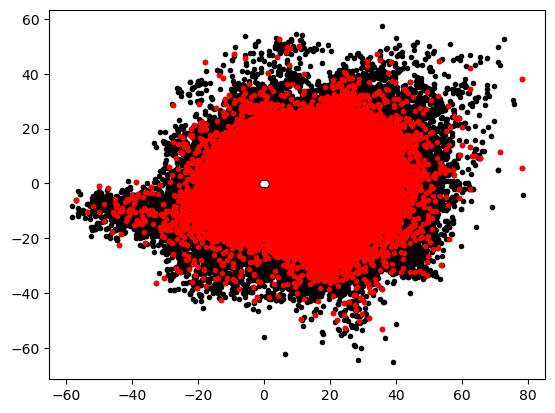

In [98]:
plt.plot(ob_uwd[idx],ob_vwd[idx],'.',color='black')
plt.plot(ob_uwd[idx[::10]],ob_vwd[idx[::10]],'.',color='red')
plt.show()

In [101]:
from sklearn.cluster import OPTICS

In [150]:
subSampleSize = 0.20  # fraction of total obs
# randomly select subSampleSize fraction of obs for clustering
rng = np.random.default_rng(seed=90210)
isub = idx#rng.choice(a=idx,size=int(np.floor(subSampleSize*np.size(idx))),replace=False)
# define features for clustering:
# 1. u-component
# 2. v-component
# predictors are stored in a matrix of {n_samples, n_features}
n_feat = 2
X = np.nan * np.ones((np.size(isub),n_feat))
X[:,0] = ob_uwd[isub]
X[:,1] = ob_vwd[isub]
clustering = OPTICS(
                                 min_samples=8,
                                 max_eps=np.sqrt(2*3.)
                                ).fit(X)

KeyboardInterrupt: 

In [ ]:
print('{:d} observations reduced to {:d} clusters with {:d} un-clustered remaining'.format(np.size(isub),np.size(np.unique(clustering.labels_))-1,np.size(np.where(clustering.labels_==-1))))

In [146]:
y=np.nan * np.ones((8,n_feat))
y[:,0] = ob_uwd[rng.choice(a=idx,size=8,replace=False)]
y[:,1] = ob_vwd[rng.choice(a=idx,size=8,replace=False)]
np.shape(y)

(8, 2)

In [145]:
def dbscan_predict(model, X):

    nr_samples = X.shape[0]

    y_new = np.ones(shape=nr_samples, dtype=int) * -1

    for i in range(nr_samples):
        diff = model.components_ - X[i, :]  # NumPy broadcasting

        dist = np.linalg.norm(diff, axis=1)  # Euclidean distance

        shortest_dist_idx = np.argmin(dist)

        if dist[shortest_dist_idx] < model.eps:
            y_new[i] = model.labels_[model.core_sample_indices_[shortest_dist_idx]]

    return y_new

In [147]:
dbscan_predict(clustering,y)

AttributeError: 'OPTICS' object has no attribute 'components_'

In [ ]:
clustering.

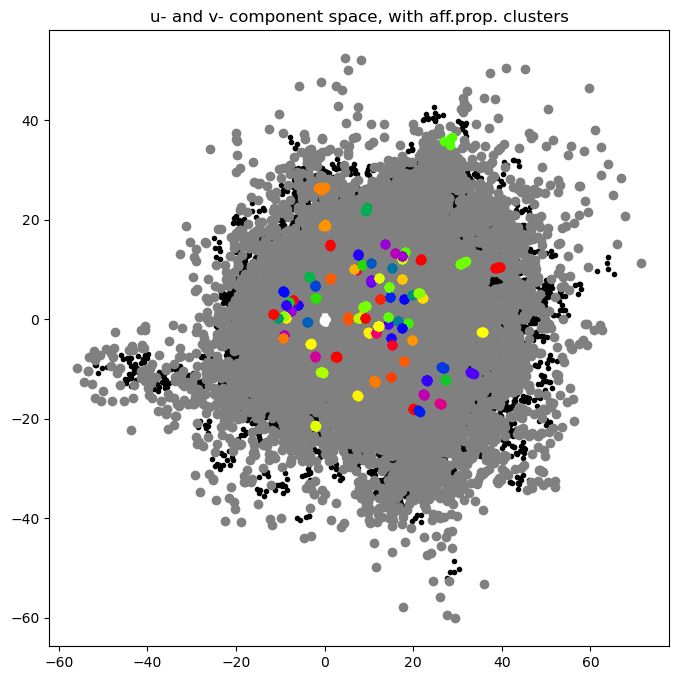

In [126]:
nClusters=np.size(np.unique(clustering.labels_))
fig, axs = plt.subplots(figsize=(8,8),ncols=1,nrows=1)
ax=axs
scalarMap = cm.ScalarMappable(cmap='prism')
scalarMapList = scalarMap.to_rgba(range(nClusters))
ax.plot(ob_uwd[isub],ob_vwd[isub],'.',color='black')
for i in range(0,nClusters,100):#range(nClusters):
    c = np.unique(clustering.labels_)[i]
    cluster_color = list(scalarMapList[i][0:3])
    if c==-1:
        cluster_color='gray'
    x=np.where(clustering.labels_==c)[0]
    ax.plot(ob_uwd[isub[x]],ob_vwd[isub[x]],'o',color=cluster_color)
ax.set_title('u- and v- component space, with aff.prop. clusters')
plt.show()


In [130]:
clustering.fit_predict(np.reshape((ob_uwd[isub[-1]],ob_vwd[isub[-1]]),(-1,1)))

ValueError: min_samples must be no greater than the number of samples (2). Got 5

In [128]:
np.shape((ob_uwd[isub[-1]],ob_vwd[isub[-1]]))

(2,)

In [17]:
# we can safely remove islands from the dataset, these will all be one-observation superobs by default
# since they have no proximity neighbors
print(np.size(np.where(w.component_labels==w.component_labels[1])),w.cardinalities[1])

537648 6


In [18]:
gdfE[f'ProxNeigh']=w.cardinalities

In [19]:
gdfE

,geometry,lat,lon,pre,tim,uwd,vwd,nob,ob_idx,pressure,time,ProxNeigh
0,POINT (111319.491 -9034690.280),-81.160004,1.000000,425.000000,-2.550000,-3.314330,13.293052,1,0,425.000000,-2.550000,2
1,POINT (939536.456 -9013539.305),-80.970001,8.440000,450.000000,-2.550000,-13.800393,8.292113,1,1,450.000000,-2.550000,6
2,POINT (921725.354 -9082556.846),-81.589996,8.280000,437.000000,-2.550000,-11.190902,9.062214,1,2,437.000000,-2.550000,3
3,POINT (551031.458 -9124858.796),-81.970001,4.950000,412.000000,-2.550000,-8.955636,14.332013,1,3,412.000000,-2.550000,2
4,POINT (732482.241 -9122631.931),-81.949997,6.580000,412.000000,-2.550000,-10.281547,13.159780,1,4,412.000000,-2.550000,2
...,...,...,...,...,...,...,...,...,...,...,...,...
582773,POINT (-687739.614 9183377.286),82.495682,-6.178070,675.200012,0.933333,7.151043,-8.226335,1,1850225,675.200012,0.933333,1
582774,POINT (-324531.239 9093149.320),81.685150,-2.915314,649.700012,0.933333,1.950893,-2.409153,1,1850226,649.700012,0.933333,1
582775,POINT (-207585.983 9098121.973),81.729820,-1.864777,627.099976,0.933333,6.066584,-0.637624,1,1850227,627.099976,0.933333,1
582776,POINT (-409981.042 9086027.087),81.621170,-3.682922,647.000000,0.933333,2.558630,-2.943367,1,1850228,647.000000,0.933333,1


In [20]:
gdfE.sort_values('ProxNeigh')

,geometry,lat,lon,pre,tim,uwd,vwd,nob,ob_idx,pressure,time,ProxNeigh
97322,POINT (15027018.674 4458345.521),40.049999,134.990005,935.700012,1.166667,-3.656770,-6.085888,1,373849,935.700012,1.166667,0
110984,POINT (17263426.836 -3335131.842),-29.959999,155.080002,357.200012,1.166667,13.300118,-1.633049,1,409875,357.200012,1.166667,0
111031,POINT (16434096.969 -2051618.249),-18.430000,147.630005,934.799988,1.166667,-4.172272,-1.040264,1,410969,934.799988,1.166667,0
111042,POINT (17149880.480 -2172956.511),-19.520000,154.059998,250.899994,-0.833333,21.263662,-9.025889,1,411000,250.899994,-0.833333,0
111092,POINT (16512020.273 -2127315.537),-19.110001,148.330002,358.399994,1.166667,16.628510,-3.534499,1,411123,358.399994,1.166667,0
...,...,...,...,...,...,...,...,...,...,...,...,...
438518,POINT (-9337883.698 -1043447.712),-9.373450,-83.883636,166.899994,2.000000,6.290029,-4.084793,1,1278710,166.899994,2.000000,535
438532,POINT (-9340027.332 -1045522.659),-9.392090,-83.902893,167.600006,2.000000,6.134878,-4.138028,1,1278735,167.600006,2.000000,536
440402,POINT (-9341973.929 -1041401.641),-9.355070,-83.920380,172.600006,-1.000000,6.556434,-7.813653,1,1282279,172.600006,-1.000000,536
442159,POINT (-9340027.332 -1045522.659),-9.392090,-83.902893,168.100006,2.000000,6.514472,-3.914289,1,1285546,168.100006,2.000000,536


In [47]:
def find_spattemp_neighbors(idx,i,y,pre,tim,Npre,Ntim):
    STneigh = np.intersect1d(Npre.radius_neighbors(np.reshape(pre[idx[i]],(-1,1)),return_distance=False)[0],
                             Ntim.radius_neighbors(np.reshape(tim[idx[i]],(-1,1)),return_distance=False)[0])
    STneigh = np.intersect1d(STneigh,np.where(y[i,:]==1))
    return STneigh

In [5]:
y=w.full()[0]

In [6]:
import scipy.sparse

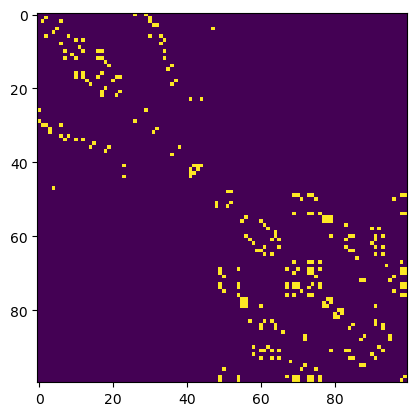

In [11]:
plt.imshow(y[0:100,0:100])
plt.show()

In [ ]:
z=scipy.sparse.csc_matrix(y[0:100000,0:100000])
y[scipy.sparse.find(z)[0][10],scipy.sparse.find(z)[1][10]]

In [30]:
t=scipy.sparse.triu(z)

In [31]:
y[scipy.sparse.find(t)[1][10],scipy.sparse.find(t)[0][10]]

1.0

In [75]:
PNeigh = neighPres.radius_neighbors(np.reshape(ob_pre[idx[0:10]],(-1,1)),return_distance=False)
TNeigh = neighTime.radius_neighbors(np.reshape(ob_tim[idx[0:10]],(-1,1)),return_distance=False)
j,i = np.where(y[0:10000,:]==1)

In [38]:
i=idx[10]
%timeit neighPres.radius_neighbors(np.reshape(ob_pre[i],(-1,1)),return_distance=False)[0]

1.12 ms ± 38.5 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [40]:
%timeit neighTime.radius_neighbors(np.reshape(ob_tim[i],(-1,1)),return_distance=False)[0]

1.02 ms ± 54.7 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [41]:
%timeit adjList.loc[adjList['focal']==i,'neighbor'].values

38.3 ms ± 630 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [45]:
y=w.full()[0]

In [46]:
%timeit np.where(y[i,:]==1)[0]

222 µs ± 8.94 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [28]:
def assign_spattemp_neighbors(df,aL,pre,tim,Npre,Ntim):
    df[f'spatTempNeigh'] = df.apply(lambda row: find_spattemp_neighbors(row['ob_idx'],aL,pre,tim,Npre,Ntim),axis=1)

In [29]:
assign_spattemp_neighbors(gdfE,adjList,ob_pre,ob_tim,neighPres,neighTime)


KeyboardInterrupt



In [ ]:
gdfE

In [6]:
# perform affinity propagation clustering on only a sub-sample of data for speed, use
# trained classifier to assign remaining obs to clusters
subSampleSize = 0.05  # fraction of total obs
# randomly select subSampleSize fraction of obs for clustering
rng = np.random.default_rng(seed=90210)
isub = rng.choice(a=idx,size=int(np.floor(subSampleSize*np.size(idx))),replace=False)

# define features for clustering:
# 1. u-component
# 2. v-component
# predictors are stored in a matrix of {n_samples, n_features}
n_feat = 2
X = np.nan * np.ones((np.size(isub),n_feat))
X[:,0] = ob_uwd[isub]
X[:,1] = ob_vwd[isub]
# define settings for affinity propagation and generate clustering
# see for details:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html#sklearn.cluster.AffinityPropagation
dampCoef  = 0.80  # can be increased up to 0.95, if not converging - lower value may or may not produce more indiv. clusters
iterMax   = 500   # set higher than iterCnv
iterCnv   = 200   # can be increased if not converging (try increasing dampCoef first, though)
cop       = True
pref      = None
affTyp    = 'euclidean'
outVerb   = True
randState = 90210  # sets random number seed, for reproducibility
clustering = AffinityPropagation(
                                 damping=dampCoef,
                                 max_iter=iterMax,
                                 convergence_iter=iterCnv,
                                 copy=cop,
                                 preference=pref,
                                 affinity=affTyp,
                                 verbose=outVerb,
                                 random_state=randState
                                ).fit(X)
nClusters = np.size(np.unique(clustering.labels_))
clusterIndices = list(np.unique(clustering.labels_))
print('{:d} observations reduced to {:d} clusters'.format(np.size(isub), nClusters))

KeyboardInterrupt: 

In [16]:
i=1
print('observation',idx[i])
# find all proximity neighbors to observation i
proxNeighbors = adjList.loc[adjList['focal']==idx[i],'neighbor'].values
print('{:d} proximity neighbors'.format(np.size(proxNeighbors)))
# find all pressure neighbors to observation i
presNeighbors = neighPres.radius_neighbors(np.reshape(ob_pre[idx[i]],(-1,1)),return_distance=False)[0]
print('{:d} pressure neighbors'.format(np.size(presNeighbors)))
# find all time neighbors to observation i
timeNeighbors = neighTime.radius_neighbors(np.reshape(ob_tim[idx[i]],(-1,1)),return_distance=False)[0]
print('{:d} time neighbors'.format(np.size(timeNeighbors)))
# construct total time-pressure-proximity neighbor list
allNeighbors = np.intersect1d(proxNeighbors,np.intersect1d(presNeighbors,timeNeighbors))
print('{:d} total neighbors'.format(np.size(allNeighbors)))

observation 1
6 proximity neighbors
143980 pressure neighbors
177667 time neighbors
2 total neighbors


In [ ]:
# genuine clusters are defined by the following characteristics:
# 1. all obs are in same proximity-group
# 2. all obs are in same aff.prop. cluster
# 3. all obs are pressure-neighbors
# 4. all obs are time-neighbors
genClusIndex=0
#obList=list(idx[prox_set])  # each value i of obList is a value of idx[prox_set], i = idx[prox_set[i]]
obList=list(np.arange(np.size(prox_set)))  # each value of obList is an index of idx[prox_set]
ob_clu=np.nan * np.ones(np.shape(ob_uwd))
while len(obList) > 0:
    loopCounter = loopCounter + 1
    # create a copy of obList that can be mutated without changing obList directly,
    # we will remove obs from this copy in-line and then assign obList to this
    # copy after mutations are over.
    obListCopy = obList.copy()
    # proximity-group requirement is automatically satisfied right now, since we
    # are operating on only obs in a single proximity-group
    #
    # select first ob in obList as a test-value, find obs with same aff.prop. cluster,
    # pressure-neighbor relation, and time-neighbor relation
    #
    # each value of obList is a value of idx[prox_set]
    srcIdx = np.intersect1d(relatPres[obList[0]],relatTime[obList[0]])
    srcIdx = np.intersect1d(srcIdx,obList)
    # filter for all clustering.labels_ that match clustering.labels_[obList[0]]
    matchIdx = np.intersect1d(srcIdx,np.where(clustering.labels_ == clustering.labels_[obList[0]]))
    # matchIdx should include obList[0], so it should never be np.size() < 1
    for mi in matchIdx:
        #  1. assign obList[mi] to genClusIndex
        #  2. remove obList[mi] from obListCopy,
        ob_clu[idx[prox_set[mi]]] = genClusIndex
        obListCopy.remove(mi)
    # assign obListCopy to obList, mutations complete
    obList = obListCopy
    # increment genClusIndex for next cluster assignment
    genClusIndex = genClusIndex + 1

In [7]:
# let's start with a large proximity-group
i=67
len(adjList.loc[adjList['focal']==i,'neighbor'])

79

In [252]:
# define features for clustering:
# 1. u-component
# 2. v-component
# predictors are stored in a matrix of {n_samples, n_features}
n_feat = 2
X = np.nan * np.ones((np.size(idx[prox_set]),n_feat))
X[:,0] = ob_uwd[idx[prox_set]]
X[:,1] = ob_vwd[idx[prox_set]]
# define settings for affinity propagation and generate clustering
# see for details:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html#sklearn.cluster.AffinityPropagation
dampCoef  = 0.50  # can be increased up to 0.95, if not converging - lower value may or may not produce more indiv. clusters
iterMax   = 500   # set higher than iterCnv
iterCnv   = 200   # can be increased if not converging (try increasing dampCoef first, though)
cop       = True
pref      = None
affTyp    = 'euclidean'
outVerb   = True
randState = 90210  # sets random number seed, for reproducibility
clustering = AffinityPropagation(
                                 damping=dampCoef,
                                 max_iter=iterMax,
                                 convergence_iter=iterCnv,
                                 copy=cop,
                                 preference=pref,
                                 affinity=affTyp,
                                 verbose=outVerb,
                                 random_state=randState
                                ).fit(X)
nClusters = np.size(np.unique(clustering.labels_))
clusterIndices = list(np.unique(clustering.labels_))
print('{:d} observations reduced to {:d} clusters'.format(np.size(idx[[prox_set]]), nClusters))

Converged after 229 iterations.
80 observations reduced to 10 clusters


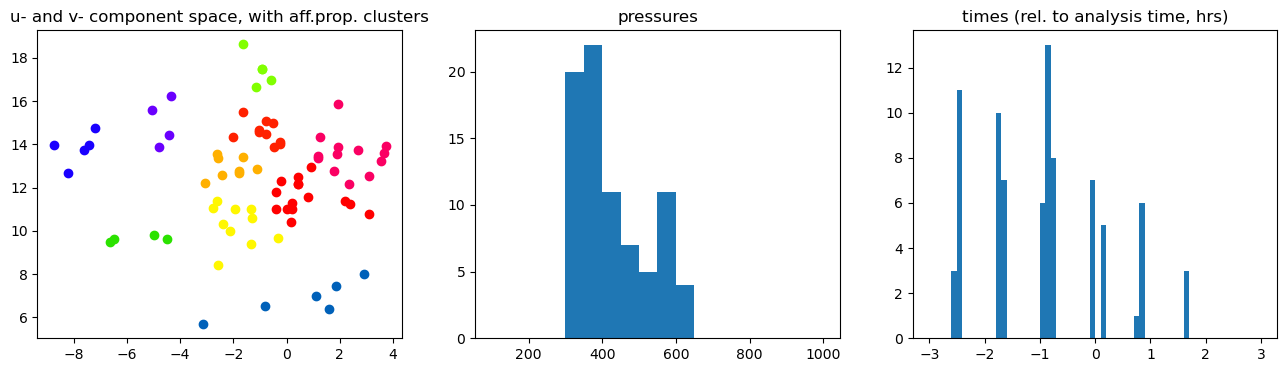

In [254]:
fig, axs = plt.subplots(figsize=(16,4),ncols=3)
ax=axs[0]
scalarMap = cm.ScalarMappable(cmap='prism')
scalarMapList = scalarMap.to_rgba(range(nClusters*10))
ax.plot(ob_uwd[idx[prox_set]],ob_vwd[idx[prox_set]],'.',color='black')
for i in range(nClusters):
    c = clusterIndices[i]
    cluster_color = list(scalarMapList[i][0:3])
    x=np.where(clustering.labels_==c)[0]
    ax.plot(ob_uwd[idx[prox_set][x]],ob_vwd[idx[prox_set][x]],'o',color=cluster_color)
ax.set_title('u- and v- component space, with aff.prop. clusters')
ax=axs[1]
ax.hist(ob_pre[idx[prox_set]],np.arange(100.,1000.1,50.))
ax.set_title('pressures')
ax=axs[2]
ax.hist(ob_tim[idx[prox_set]],np.arange(-3.,3.1,0.1))
ax.set_title('times (rel. to analysis time, hrs)')
plt.show()

In [5]:
from sklearn.neighbors import NearestNeighbors
thresPres = 125.
neighPres = NearestNeighbors(radius=thresPres)
neighPres.fit(np.reshape(ob_pre[idx],(-1,1)))

NearestNeighbors(radius=125.0)

In [28]:
# let's create neighbor relationships based on pressure and time, using from sklearn.neighbors.NearestNeighbors()
from sklearn.neighbors import NearestNeighbors
thresPres = 125.
thresTime = 1.
neighPres = NearestNeighbors(radius=thresPres)
neighPres.fit(np.reshape(ob_pre[idx[prox_set]],(-1,1)))
neighTime = NearestNeighbors(radius=thresTime)
neighTime.fit(np.reshape(ob_tim[idx[prox_set]],(-1,1)))

relatPres= neighPres.radius_neighbors(np.reshape(ob_pre[idx[prox_set]],(-1,1)),return_distance=False)
relatTime= neighTime.radius_neighbors(np.reshape(ob_tim[idx[prox_set]],(-1,1)),return_distance=False)

In [255]:
# genuine clusters are defined by the following characteristics:
# 1. all obs are in same proximity-group
# 2. all obs are in same aff.prop. cluster
# 3. all obs are pressure-neighbors
# 4. all obs are time-neighbors
genClusIndex=0
#obList=list(idx[prox_set])  # each value i of obList is a value of idx[prox_set], i = idx[prox_set[i]]
obList=list(np.arange(np.size(prox_set)))  # each value of obList is an index of idx[prox_set]
ob_clu=np.nan * np.ones(np.shape(ob_uwd))
while len(obList) > 0:
    loopCounter = loopCounter + 1
    # create a copy of obList that can be mutated without changing obList directly,
    # we will remove obs from this copy in-line and then assign obList to this
    # copy after mutations are over.
    obListCopy = obList.copy()
    # proximity-group requirement is automatically satisfied right now, since we
    # are operating on only obs in a single proximity-group
    #
    # select first ob in obList as a test-value, find obs with same aff.prop. cluster,
    # pressure-neighbor relation, and time-neighbor relation
    #
    # each value of obList is a value of idx[prox_set]
    srcIdx = np.intersect1d(relatPres[obList[0]],relatTime[obList[0]])
    srcIdx = np.intersect1d(srcIdx,obList)
    # filter for all clustering.labels_ that match clustering.labels_[obList[0]]
    matchIdx = np.intersect1d(srcIdx,np.where(clustering.labels_ == clustering.labels_[obList[0]]))
    # matchIdx should include obList[0], so it should never be np.size() < 1
    for mi in matchIdx:
        #  1. assign obList[mi] to genClusIndex
        #  2. remove obList[mi] from obListCopy,
        ob_clu[idx[prox_set[mi]]] = genClusIndex
        obListCopy.remove(mi)
    # assign obListCopy to obList, mutations complete
    obList = obListCopy
    # increment genClusIndex for next cluster assignment
    genClusIndex = genClusIndex + 1

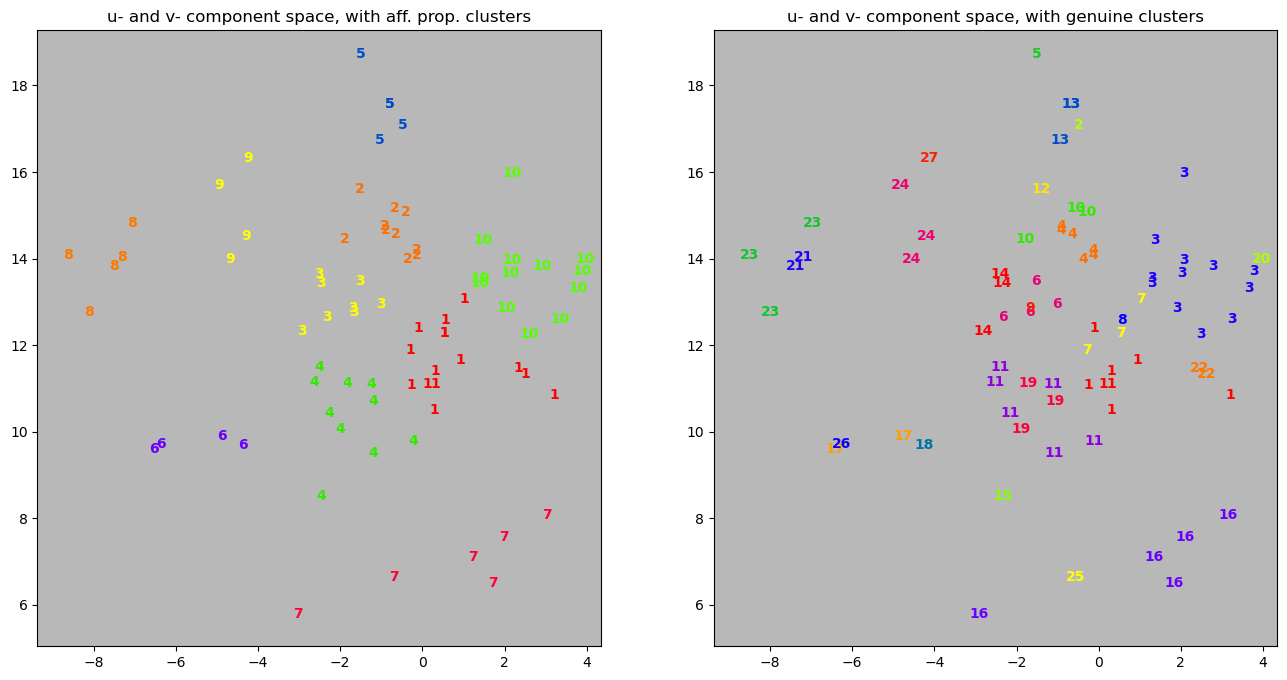

In [290]:
fig, axs = plt.subplots(figsize=(16,8),ncols=2)
ax=axs[0]
nClusters = np.size(np.unique(clustering.labels_))
scalarMap = cm.ScalarMappable(cmap='prism')
scalarMapList = scalarMap.to_rgba(range(nClusters))
ax.plot(ob_uwd[idx[prox_set]],ob_vwd[idx[prox_set]],'o',color='gray',alpha=0.)
for i in range(nClusters):
    c = clusterIndices[i]
    cluster_color = list(scalarMapList[i][0:3])
    x=np.where(clustering.labels_==c)[0]
    for xi in x:
        ax.text(ob_uwd[idx[prox_set][xi]],ob_vwd[idx[prox_set][xi]],str(c+1),color=cluster_color,fontweight='bold',multialignment='center')
ax.set_title('u- and v- component space, with aff. prop. clusters')
ax.set_facecolor('#B8B8B8')
ax=axs[1]
nClusters=genClusIndex+1
scalarMap = cm.ScalarMappable(cmap='prism')
scalarMapList = scalarMap.to_rgba(range(nClusters))
ax.plot(ob_uwd[idx[prox_set]],ob_vwd[idx[prox_set]],'o',color='gray',alpha=0.)
for i in range(nClusters):
    c = i
    cluster_color = list(scalarMapList[i][0:3])
    x=np.where(ob_clu[idx[prox_set]]==c)[0]
    for xi in x:
        ax.text(ob_uwd[idx[prox_set][xi]],ob_vwd[idx[prox_set][xi]],str(c+1),color=cluster_color,fontweight='bold',multialignment='center')
ax.set_title('u- and v- component space, with genuine clusters')
ax.set_facecolor('#B8B8B8')
plt.show()

In [250]:
plt.colorbar(ax=axs[0])

RuntimeError: No mappable was found to use for colorbar creation. First define a mappable such as an image (with imshow) or a contour set (with contourf).

<Figure size 640x480 with 0 Axes>

In [243]:
nClusters

1

In [42]:
relatTime[obList[0]]

array([29, 30, 14, 15, 31, 63, 64, 65, 16, 17, 24, 48, 47, 46, 45, 44, 43,
       42, 32, 77, 78, 79])

In [45]:
idx[prox_set[np.intersect1d(relatPres[obList[0]],relatTime[obList[0]])]]

array([    366,     372,     391,    1420,    2637,    2641, 1819805,
       1819812, 1820071, 1820078, 1820114])

In [71]:
obList=list(np.arange(np.size(prox_set))) 
srcIdx=np.intersect1d(relatPres[obList[0]],relatTime[obList[0]])
affPropMems = srcIdx[np.where(clustering.labels_[srcIdx] == clustering.labels_[obList[0]])]
affPropMems

array([ 0,  1,  2,  3,  4,  7, 74, 78])

In [78]:
ob_pre[idx[prox_set[relatPres[obList[60]]]]] - ob_pre[idx[prox_set[obList[60]]]]

array([ 49.899994 ,  61.700012 ,  77.30002  ,  32.       ,  42.200012 ,
        46.100006 ,  74.100006 ,  47.700012 ,  39.80002  ,  55.100006 ,
        19.399994 ,  19.399994 ,  27.100006 ,  35.899994 ,  26.399994 ,
         6.399994 ,  70.20001  ,  41.200012 ,  78.600006 ,  40.80002  ,
        40.399994 ,  50.700012 ,  35.80002  ,  32.399994 ,  60.5      ,
        43.5      ,  48.30002  ,  35.80002  ,  15.100006 ,  16.       ,
        -6.600006 ,  19.100006 ,  -1.6999817,   0.       ,   5.399994 ,
        17.600006 ,  70.30002  ,  76.80002  ,   3.600006 ,  23.700012 ,
        82.30002  ,  87.100006 ,  87.100006 ,  87.100006 ,  86.20001  ,
        90.20001  ,  91.399994 , 124.100006 , 116.       ,  99.100006 ,
       112.100006 , 124.100006 , 124.100006 ], dtype=float32)

In [69]:
print(ob_tim[idx[prox_set[obList[0]]]],ob_tim[idx[prox_set[srcIdx]]]-ob_tim[idx[prox_set[obList[0]]]])

-0.9 [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.         -0.7166667   0.11666662  1.
  0.         -0.8333334  -0.03333336 -0.7166667  -0.7166667  -0.7166667
  0.11666662  1.          1.          0.          0.          0.
 -0.8333334  -0.7166667  -0.7166667  -0.7166667   0.11666662  0.11666662
  0.11666662  0.11666662  1.          1.        ]


In [59]:
srcIdx = np.intersect1d(relatPres[obList[0]],relatTime[obList[0]])
np.where(clustering.labels_[srcIdx] == clustering.labels_[obList[0]])

(array([10]),)

In [36]:
# define features for clustering:
# 1. u-component, normalized
# 2. v-component, normalized
# 3. pressure, normalized
# 4. time, normalized
# normalized: (x-mean(x))/std(x)
# predictors are stored in a matrix of {n_samples, n_features}
n_feat = 2
X = np.nan * np.ones((np.size(idx[prox_set]),n_feat))
X[:,0] = ob_uwd[idx[prox_set]]#(ob_uwd[idx[prox_set]]-np.mean(ob_uwd[idx[prox_set]]))/np.std(ob_uwd[idx[prox_set]])
X[:,1] = ob_vwd[idx[prox_set]]#(ob_vwd[idx[prox_set]]-np.mean(ob_vwd[idx[prox_set]]))/np.std(ob_vwd[idx[prox_set]])
#X[:,2] = (ob_tim[idx[prox_set]]-np.mean(ob_tim[idx[prox_set]]))/np.std(ob_tim[idx[prox_set]])
#X[:,3] = (ob_pre[idx[prox_set]]-np.mean(ob_pre[idx[prox_set]]))/np.std(ob_pre[idx[prox_set]])
print(np.shape(X))
# define settings for affinity propagation and generate clustering
# see for details:
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html#sklearn.cluster.AffinityPropagation
dampCoef  = 0.50  # can be increased up to 0.95, if not converging - lower value may or may not produce more indiv. clusters
iterMax   = 500   # set higher than iterCnv
iterCnv   = 200   # can be increased if not converging (try increasing dampCoef first, though)
cop       = True
pref      = None
affTyp    = 'euclidean'
outVerb   = True
randState = 90210  # sets random number seed, for reproducibility
clustering = AffinityPropagation(
                                 damping=dampCoef,
                                 max_iter=iterMax,
                                 convergence_iter=iterCnv,
                                 copy=cop,
                                 preference=pref,
                                 affinity=affTyp,
                                 verbose=outVerb,
                                 random_state=randState
                                ).fit(X)
nClusters = np.size(np.unique(clustering.labels_))
clusterIndices = list(np.unique(clustering.labels_))
print('{:d} observations reduced to {:d} clusters'.format(np.size(idx[[prox_set]]), nClusters))

(80, 2)
Converged after 229 iterations.
80 observations reduced to 10 clusters


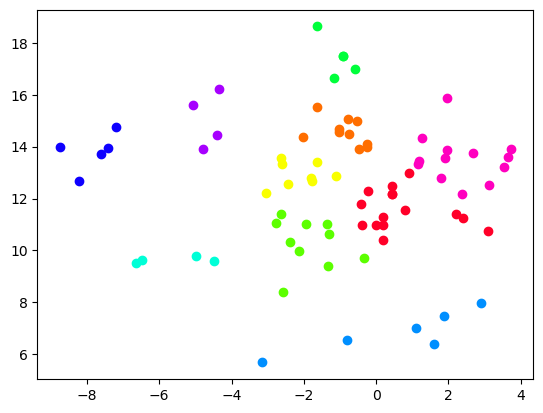

In [37]:
scalarMap = cm.ScalarMappable(cmap='gist_rainbow')
scalarMapList = scalarMap.to_rgba(range(nClusters))
plt.plot(ob_uwd[idx[prox_set]],ob_vwd[idx[prox_set]],'.',color='black')
for i in range(nClusters):
    c = clusterIndices[i]
    cluster_color = list(scalarMapList[i][0:3])
    x=np.where(clustering.labels_==c)[0]
    plt.plot(ob_uwd[idx[prox_set][x]],ob_vwd[idx[prox_set][x]],'o',color=cluster_color)
plt.show()

In [40]:
ob_tim[idx[prox_set]]

array([-0.9       , -0.9       , -0.9       , -0.9       , -0.9       ,
       -2.55      , -0.9       , -0.9       , -0.9       , -0.9       ,
       -1.7333333 , -1.7333333 , -1.7333333 , -1.7333333 , -0.05      ,
       -0.05      ,  1.6333333 ,  1.6333333 , -2.4833333 , -2.4833333 ,
       -2.4833333 , -1.6166667 , -0.78333336, -0.78333336,  0.1       ,
       -0.9       , -1.7333333 , -1.7333333 , -0.93333334, -0.05      ,
       -0.05      , -0.05      ,  1.6333333 , -2.4833333 , -2.4833333 ,
       -2.4833333 , -2.4833333 , -2.4833333 , -1.6166667 , -1.6166667 ,
       -1.6166667 , -0.78333336,  0.1       ,  0.1       ,  0.9       ,
        0.9       ,  0.9       ,  0.9       ,  0.9       , -2.55      ,
       -2.55      , -0.9       , -0.9       , -0.9       , -1.7333333 ,
       -1.7333333 , -1.7333333 , -1.7333333 , -0.93333334, -0.93333334,
       -0.93333334, -0.93333334, -0.93333334, -0.05      , -0.05      ,
        0.75      , -2.4833333 , -2.4833333 , -2.4833333 , -1.61

In [50]:
p_neighbors={}
for i in range(np.size(idx)):
    neighs = np.where((np.abs(ob_pre[idx]-ob_pre[idx[i]]) <= 225.) & (idx!=i))[0]
    p_neighbors[i]=list(neighs)
    


KeyboardInterrupt



[0,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99,
 100,
 101,
 102,
 103,
 104,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 133,
 134,
 135,
 136,
 137,
 138,
 139,
 140,
 141,
 142,
 143,
 144,
 145,
 146,
 147,
 148,
 149,
 150,
 151,
 152,
 153,
 154,
 155,
 156,
 157,
 158,
 159,
 160,
 161,
 162,
 163,
 164,
 165,
 166,
 167,
 168,
 169,
 170,
 171,
 172,
 173,
 174,
 175,
 176,
 177,
 178,
 179,
 180,
 181,
 182,
 183,
 184,
 185

In [4]:
from sklearn.neighbors import NearestNeighbors

In [30]:
neigh = NearestNeighbors(radius=125.)

In [31]:
neigh.fit(np.reshape(ob_pre[idx],(-1,1)))

NearestNeighbors(radius=125.0)

In [ ]:
rng = neigh.radius_neighbors(np.reshape(ob_pre[idx],(-1,1)),return_distance=False)

In [43]:
np.shape(rng)

(1000,)

In [44]:
rng

array([array([    62,     83,     58, ..., 582727, 582745, 582726]),
       array([    55,     77,     78, ..., 582753, 579794, 582551]),
       array([ 14131,  12232,  14134, ..., 582744, 582752, 582756]),
       array([    90,  16994,  14207, ..., 582755, 582751, 582763]),
       array([    90,  16994,  14207, ..., 582755, 582751, 582763]),
       array([ 14131,  12232,  14134, ..., 582744, 582752, 582756]),
       array([    90,  16994,  14207, ..., 582755, 582751, 582763]),
       array([    62,     83,     58, ..., 582727, 582745, 582726]),
       array([ 14131,  12232,  14134, ..., 582744, 582752, 582756]),
       array([    90,  16994,  14207, ..., 582755, 582751, 582763]),
       array([    90,  16994,  14207, ..., 582755, 582751, 582763]),
       array([    62,     83,     58, ..., 582727, 582745, 582726]),
       array([    62,     83,     58, ..., 582727, 582745, 582726]),
       array([    62,     83,     58, ..., 582727, 582745, 582726]),
       array([    62,     83,     

In [24]:
[list(ob_pre[idx[0:2]])]

[[425.0, 450.0]]

In [35]:
np.shape([[500.],[1000.]])

(2, 1)